In [1]:
#these column names don't mean very much to us right now 
##we will a look at variables by mapping encoded column names to label

import pandas as pd

p_file = "../1_Raw_Data/data_persons_ca_1yr/psam_p06_master.csv"
all_headers_persons = pd.read_csv(p_file, nrows=0).columns.tolist()

print("Number of columns:", len(all_headers_persons))
print("First 20 columns:", all_headers_persons[:20])
print("Last 10 columns:", all_headers_persons[-10:])

Number of columns: 278
First 20 columns: ['RT', 'SERIALNO', 'DIVISION', 'SPORDER', 'PUMA', 'REGION', 'ADJINC', 'PWGTP', 'AGEP', 'CIT', 'CITWP', 'COW', 'DDRS', 'DEAR', 'DEYE', 'DOUT', 'DPHY', 'DRAT', 'DRATX', 'DREM']
Last 10 columns: ['PWGTP72', 'PWGTP73', 'PWGTP74', 'PWGTP75', 'PWGTP76', 'PWGTP77', 'PWGTP78', 'PWGTP79', 'PWGTP80', 'year']


In [2]:
import pandas as pd
import requests
import json

# 1) get column names
p_file = "../1_Raw_Data/data_persons_ca_1yr/psam_p06_master.csv"
cols = pd.read_csv(p_file, nrows=0).columns.tolist()

print("Columns in file:", len(cols))
print("Example columns:", cols[:12])

# 2) fetch Census metadata dictionary
url = "https://api.census.gov/data/2023/acs/acs5/pums/variables.json"
meta = requests.get(url)
meta.raise_for_status()
vardict = meta.json()["variables"]

# 3) map each column -> explanation
rows = []
for c in cols:
    info = vardict.get(c, {})
    values_obj = info.get("values")
    rows.append({
        "column": c,
        "label": info.get("label"),
        "predicateType": info.get("predicateType"),
        "values_json": json.dumps(values_obj) if values_obj is not None else None
    })

df_dict = pd.DataFrame(rows)

# 5) save
df_dict.to_csv("EDA_data/all_pums_person_ca_data_dictionary.csv", index=False)
df_dict.head(20)

#see the full result of columns mapped to label (column explanation) in EDA_data/all_pums_person_us_data_dictionary.csv

Columns in file: 278
Example columns: ['RT', 'SERIALNO', 'DIVISION', 'SPORDER', 'PUMA', 'REGION', 'ADJINC', 'PWGTP', 'AGEP', 'CIT', 'CITWP', 'COW']


,column,label,predicateType,values_json
0,RT,Record Type,string,"{""item"": {""H"": ""Housing Record or Group Quarte..."
1,SERIALNO,Housing unit/GQ person serial number,string,None
2,DIVISION,Division code,None,"{""item"": {""7"": ""West South Central (South Regi..."
3,SPORDER,Person number,int,"{""range"": [{""min"": ""1"", ""max"": ""20"", ""descript..."
4,PUMA,Public use microdata area code (PUMA) based on...,string,"{""item"": {""00605"": ""Public use microdata area ..."
5,REGION,Region code,None,"{""item"": {""1"": ""Northeast"", ""9"": ""Puerto Rico""..."
6,ADJINC,Adjustment factor for income and earnings doll...,int,"{""item"": {""1019518"": ""2023 factor (1.019518 * ..."
7,PWGTP,Person weight,int,"{""range"": [{""min"": ""1"", ""max"": ""9999"", ""descri..."
8,AGEP,Age,int,"{""item"": {""0"": ""Under 1 year""}, ""range"": [{""mi..."
9,CIT,Citizenship status,int,"{""item"": {""2"": ""Born in Puerto Rico, Guam, the..."


In [3]:
# as you can see from EDA_data/all_pums_person_us_data_dictionary.csv, not all of these columns are useful
## for example, columns that start with F are all allocation flags i.e. missing information inferred using stat methods
### all columns that start with PWG are person weights are used to produce population estimates from sample data
### we don't need these 

## dropping useless columns

def is_useless(col):
    if col.startswith("PWG"):      # person weights + replicates
        return True
    if col.startswith("F"):        # allocation flags
        return True
    if col in ["RT", "SERIALNO", "SPORDER"]:  # pure identifiers
        return True
    return False

df_clean = df_dict.loc[~df_dict["column"].apply(is_useless)].copy()

print("Clean dictionary shape:", df_clean.shape)
df_clean.head()

df_clean.to_csv(
    "EDA_data/suggested_clean_data_dictionary.csv",
    index=False
)

print("Saved: suggested_clean_data_dictionary.csv")

Clean dictionary shape: (118, 4)
Saved: suggested_clean_data_dictionary.csv


In [4]:
## 118 variables is still too many, lets try to cut it down further
# lets try to remove: columns with too many null values, columns of variables that measure the same concept at different resolutions etc. 
import pandas as pd

df = pd.read_csv(
    "EDA_data/suggested_clean_data_dictionary.csv"
)

print("Starting columns:", df.shape[0])

Starting columns: 118


In [5]:
import pandas as pd

dict_path = "EDA_data/suggested_clean_data_dictionary.csv"
df_dict = pd.read_csv(dict_path)

candidate_cols = df_dict["column"].tolist()
print("Number of candidate columns:", len(candidate_cols))

Number of candidate columns: 118


In [6]:
p_file = "../1_Raw_Data/data_persons_ca_1yr/psam_p06_master.csv"

df = pd.read_csv(
    p_file,
    usecols=candidate_cols
)

print("Shape of loaded data:", df.shape)

null_summary = (
    df.isna()
      .sum()
      .reset_index()
      .rename(columns={"index": "column", 0: "n_null"})
)

null_summary["pct_null"] = null_summary["n_null"] / len(df)

null_summary = null_summary.sort_values("pct_null", ascending=False)

# load dictionary if not already loaded
df_dict = pd.read_csv(
    "EDA_data/suggested_clean_data_dictionary.csv"
)

# keep only what we need
labels = df_dict[["column", "label"]]

# merge labels into null summary
null_summary = null_summary.merge(
    labels,
    on="column",
    how="left"
)

# reorder columns for readability
null_summary = null_summary[
    ["column", "label", "n_null", "pct_null"]
]


Shape of loaded data: (1928458, 118)


In [7]:
null_summary.head(60)

,column,label,n_null,pct_null
0,GCM,Length of time responsible for grandchildren,1917736,0.994440
1,DRAT,Veteran service connected disability rating (p...,1907260,0.989008
2,GCR,Grandparents responsible for grandchildren,1876176,0.972889
3,SFR,Subfamily relationship,1841007,0.954652
4,SFN,Subfamily number,1841007,0.954652
5,VPS,Veteran period of service,1839864,0.954060
6,MLPJ,Served World War II (December 1941 - December ...,1839864,0.954060
7,MLPE,Served Vietnam era (August 1964 - April 1975),1839864,0.954060
8,MLPCD,Served May 1975 - July 1990,1839864,0.954060
9,MLPH,Served Korean War (July 1950 - January 1955),1839864,0.954060


In [8]:
# lets drop any columns that have over 60% null values 

HIGH_NULL_CUTOFF = 0.60

# 1) Load your current clean dictionary (the 123-col list)
df_dict = pd.read_csv(dict_path)
candidate_cols = df_dict["column"].tolist()

# 2) Load ONLY those columns from the person CSV
df = pd.read_csv(p_file, usecols=candidate_cols)

# 3) Compute null rates
null_summary = (
    df.isna()
      .sum()
      .reset_index()
      .rename(columns={"index": "column", 0: "n_null"})
)
null_summary["pct_null"] = null_summary["n_null"] / len(df)

# 4) Identify high-null columns to drop
high_null_cols = null_summary.loc[
    null_summary["pct_null"] >= HIGH_NULL_CUTOFF,
    "column"
].tolist()

print(f"Columns in dict before: {len(candidate_cols)}")
print(f"Dropping (pct_null >= {HIGH_NULL_CUTOFF}): {len(high_null_cols)}")
print("Dropped columns:", high_null_cols)

# 5) Prune dictionary and overwrite the same file
df_dict_pruned = df_dict.loc[~df_dict["column"].isin(high_null_cols)].copy()
df_dict_pruned.to_csv(dict_path, index=False)

print(f"Columns in dict after: {df_dict_pruned.shape[0]}")

Columns in dict before: 118
Dropping (pct_null >= 0.6): 31
Dropped columns: ['CITWP', 'DRAT', 'DRATX', 'ENG', 'GCM', 'GCR', 'JWMNP', 'JWRIP', 'MLPA', 'MLPB', 'MLPCD', 'MLPE', 'MLPFG', 'MLPH', 'MLPJ', 'SCHG', 'YOEP', 'DECADE', 'DRIVESP', 'ESP', 'JWAP', 'JWDP', 'LANP', 'MIGPUMA', 'MIGSP', 'NOP', 'SCIENGP', 'SCIENGRLP', 'SFN', 'SFR', 'VPS']
Columns in dict after: 87


In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure POVPIP is numeric and drop missing values for exploration
povpip = pd.to_numeric(df["POVPIP"], errors="coerce").dropna()

# Basic summary statistics
povpip.describe()


count    1.857626e+06
mean     3.393265e+02
std      1.664055e+02
min      0.000000e+00
25%      1.940000e+02
50%      3.810000e+02
75%      5.010000e+02
max      5.010000e+02
Name: POVPIP, dtype: float64

## Target Variable Analysis (POVPIP)

POVPIP is the income-to-poverty ratio recode:
- Values 0-100: Below poverty threshold (100 = exactly at poverty line)
- Values 101-500: Above poverty threshold (up to 5x poverty line)
- Value 501: 501% or more of poverty threshold (capped)

For our **multiclass classification** task, we define 4 poverty levels based on POVPIP:
- **Deep Poverty** (0-50): Severe economic hardship, less than half the poverty threshold
- **Poverty** (51-100): Below poverty line
- **Near Poverty** (101-200): Above poverty line but vulnerable, low financial buffer
- **Stable** (201+): More than twice the poverty threshold, relatively secure

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Load data
p_file = "../1_Raw_Data/data_persons_ca_1yr/psam_p06_master.csv"
dict_path = "EDA_data/suggested_clean_data_dictionary.csv"

df_dict = pd.read_csv(dict_path)
candidate_cols = df_dict["column"].tolist()

print(f"Loading {len(candidate_cols)} columns...")
df = pd.read_csv(p_file, usecols=candidate_cols)
print(f"Data shape: {df.shape}")
print(f"Total records: {len(df):,}")

Loading 87 columns...
Data shape: (1928458, 87)
Total records: 1,928,458


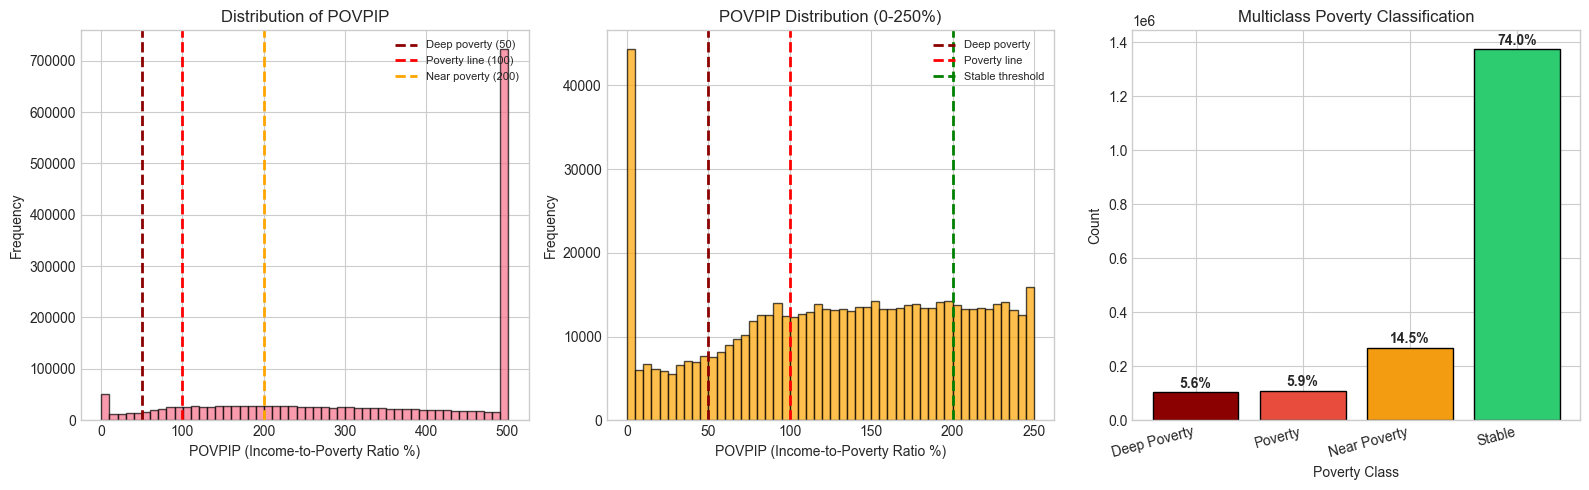


Poverty Statistics (Multiclass):
Records with POVPIP data: 1,857,626
Records missing POVPIP: 70,832

Poverty Class Breakdown:
  Deep Poverty   : 104,528 (5.63%)
  Poverty        : 109,241 (5.88%)
  Near Poverty   : 268,696 (14.46%)
  Stable         : 1,375,161 (74.03%)


In [11]:
# POVPIP Distribution Analysis
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Raw POVPIP histogram with class boundaries
povpip = df["POVPIP"].dropna()
axes[0].hist(povpip, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=50, color='darkred', linestyle='--', linewidth=2, label='Deep poverty (50)')
axes[0].axvline(x=100, color='red', linestyle='--', linewidth=2, label='Poverty line (100)')
axes[0].axvline(x=200, color='orange', linestyle='--', linewidth=2, label='Near poverty (200)')
axes[0].set_xlabel('POVPIP (Income-to-Poverty Ratio %)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of POVPIP')
axes[0].legend(fontsize=8)

# 2. Zoomed in view (0-250) with class boundaries
axes[1].hist(povpip[povpip <= 250], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(x=50, color='darkred', linestyle='--', linewidth=2, label='Deep poverty')
axes[1].axvline(x=100, color='red', linestyle='--', linewidth=2, label='Poverty line')
axes[1].axvline(x=200, color='green', linestyle='--', linewidth=2, label='Stable threshold')
axes[1].set_xlabel('POVPIP (Income-to-Poverty Ratio %)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('POVPIP Distribution (0-250%)')
axes[1].legend(fontsize=8)

# 3. Create multiclass poverty classification
def classify_poverty(povpip_val):
    if pd.isna(povpip_val):
        return None
    elif povpip_val <= 50:
        return 'Deep Poverty'
    elif povpip_val <= 100:
        return 'Poverty'
    elif povpip_val <= 200:
        return 'Near Poverty'
    else:
        return 'Stable'

df['poverty_class'] = df['POVPIP'].apply(classify_poverty)

# Order for display
class_order = ['Deep Poverty', 'Poverty', 'Near Poverty', 'Stable']
class_counts = df['poverty_class'].value_counts().reindex(class_order)
class_colors = ['#8B0000', '#e74c3c', '#f39c12', '#2ecc71']

bars = axes[2].bar(class_order, class_counts.values, color=class_colors, edgecolor='black')
axes[2].set_ylabel('Count')
axes[2].set_xlabel('Poverty Class')
axes[2].set_title('Multiclass Poverty Classification')
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=15, ha='right')

# Add percentage labels on bars
total_valid = df['poverty_class'].notna().sum()
for bar, count in zip(bars, class_counts.values):
    pct = count / total_valid * 100
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000, 
                 f'{pct:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('EDA_data/povpip_distribution_multiclass.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPoverty Statistics (Multiclass):")
print(f"Records with POVPIP data: {povpip.shape[0]:,}")
print(f"Records missing POVPIP: {df['POVPIP'].isna().sum():,}")
print(f"\nPoverty Class Breakdown:")
for cls in class_order:
    count = class_counts[cls]
    pct = count / total_valid * 100
    print(f"  {cls:15}: {count:,} ({pct:.2f}%)")

## Correlation Analysis with POVPIP

We'll compute correlations between numeric features and the target variable (POVPIP) to identify which features are most predictive of poverty status.

In [12]:
# Identify numeric columns for correlation analysis
import warnings

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove POVPIP and poverty (our target) from feature list
feature_cols = [c for c in numeric_cols if c not in ['POVPIP', 'poverty']]

print(f"Total numeric features for correlation: {len(feature_cols)}")

# Calculate correlation with POVPIP (using only non-null POVPIP records)
df_valid = df[df['POVPIP'].notna()].copy()

correlations = {}
for col in feature_cols:
    col_data = df_valid[col].dropna()
    
    # Skip if not enough data or constant values
    if len(col_data) < 100:
        continue
    if col_data.nunique() <= 1:
        continue
    
    # Get matching POVPIP values
    valid_idx = col_data.index
    povpip_matched = df_valid.loc[valid_idx, 'POVPIP']
    
    # Standardize to avoid overflow with large values
    col_standardized = (col_data - col_data.mean()) / (col_data.std() + 1e-10)
    povpip_standardized = (povpip_matched - povpip_matched.mean()) / (povpip_matched.std() + 1e-10)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            corr, p_val = stats.pearsonr(col_standardized, povpip_standardized)
            if not np.isnan(corr) and not np.isinf(corr):
                correlations[col] = {'correlation': corr, 'p_value': p_val, 'abs_corr': abs(corr)}
        except Exception:
            pass  # Skip problematic columns

# Convert to DataFrame and sort by absolute correlation
corr_df = pd.DataFrame(correlations).T
corr_df = corr_df.sort_values('abs_corr', ascending=False)
corr_df = corr_df.reset_index().rename(columns={'index': 'column'})

# Merge with labels for interpretability
corr_df = corr_df.merge(df_dict[['column', 'label']], on='column', how='left')

# Create a short label for display
corr_df['short_label'] = corr_df['label'].apply(lambda x: str(x)[:45] + '...' if len(str(x)) > 45 else str(x))
corr_df['display_name'] = corr_df['column'] + ' - ' + corr_df['short_label']

print(f"\nTop 35 features correlated with POVPIP (income-to-poverty ratio):")
print("-" * 90)
for i, row in corr_df.head(35).iterrows():
    print(f"{row['column']:12} | r={row['correlation']:+.3f} | {row['short_label']}")

Total numeric features for correlation: 84

Top 35 features correlated with POVPIP (income-to-poverty ratio):
------------------------------------------------------------------------------------------
PRIVCOV      | r=-0.470 | Private health insurance coverage recode
HINS4        | r=+0.454 | Medicaid, Medical Assistance, or any kind of ...
HINS1        | r=-0.439 | Insurance through a current or former employe...
PINCP        | r=+0.416 | Total person's income (use ADJINC to adjust t...
PERNP        | r=+0.372 | Total person's earnings (use ADJINC to adjust...
WAGP         | r=+0.363 | Wages or salary income past 12 months (use AD...
PUBCOV       | r=+0.350 | Public health coverage recode
OCCP         | r=-0.284 | Occupation recode for 2018 and later based on...
WRK          | r=-0.265 | Worked last week
SCHL         | r=+0.264 | Educational attainment
ESR          | r=-0.250 | Employment status recode
WKL          | r=-0.245 | When last worked
MSP          | r=-0.244 | Married, spous

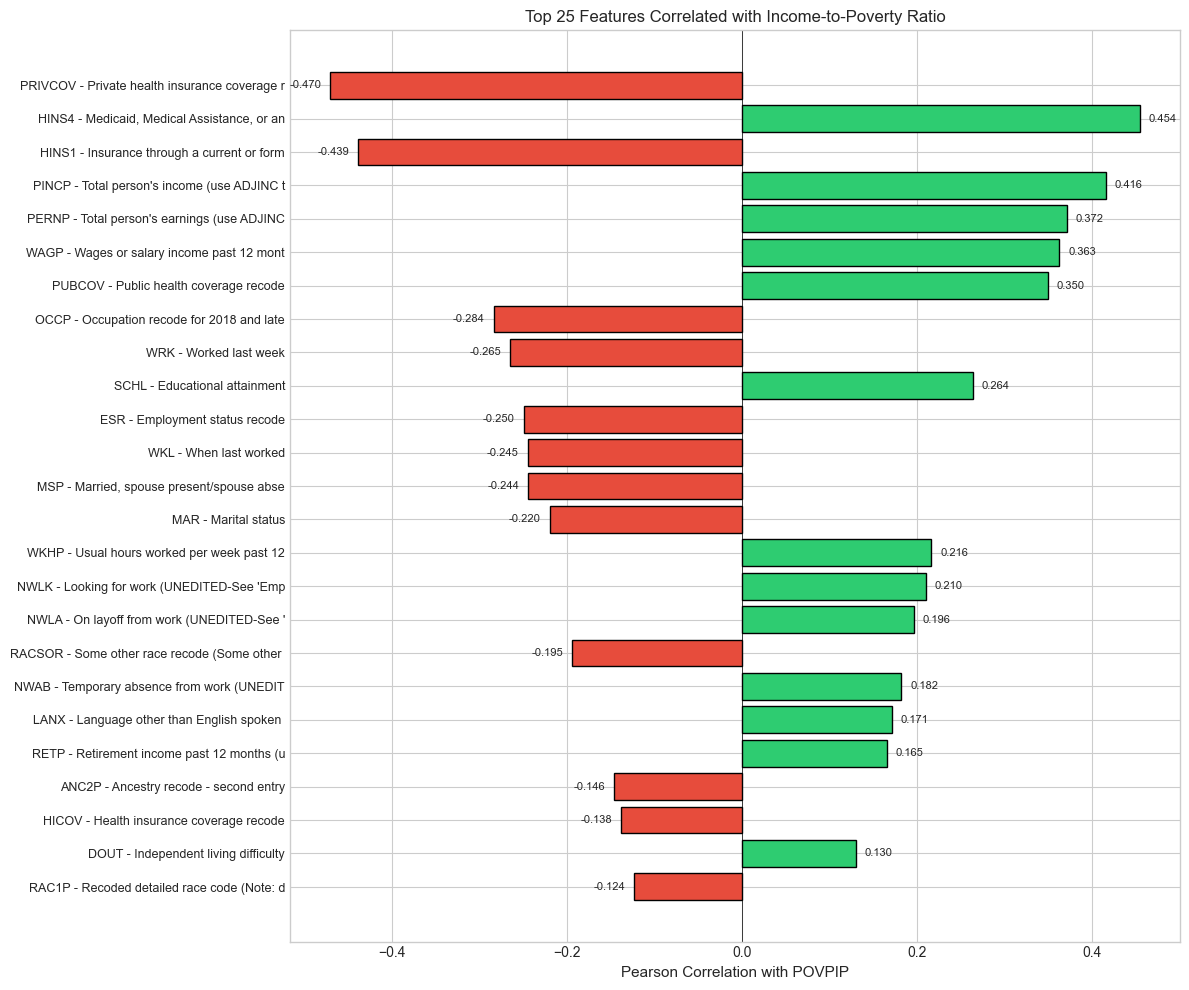


Interpretation:
- GREEN (positive): Higher values = HIGHER income-to-poverty ratio (less likely to be poor)
- RED (negative): Higher values = LOWER income-to-poverty ratio (more likely to be poor)


In [13]:
# Visualize top correlations with POVPIP (with labels!)
top_n = 25
top_corr = corr_df.head(top_n).copy()

fig, ax = plt.subplots(figsize=(12, 10))
colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in top_corr['correlation']]

# Use display names (code + short label)
y_labels = [f"{row['column']} - {row['short_label'][:35]}" for _, row in top_corr.iterrows()]

ax.barh(range(len(top_corr)), top_corr['correlation'], color=colors, edgecolor='black')
ax.set_yticks(range(len(top_corr)))
ax.set_yticklabels(y_labels, fontsize=9)
ax.set_xlabel('Pearson Correlation with POVPIP', fontsize=11)
ax.set_title(f'Top {top_n} Features Correlated with Income-to-Poverty Ratio', fontsize=12)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.invert_yaxis()

# Add correlation values on bars
for i, (idx, row) in enumerate(top_corr.iterrows()):
    ax.text(row['correlation'] + 0.01 if row['correlation'] > 0 else row['correlation'] - 0.01, 
            i, f"{row['correlation']:.3f}", va='center', 
            ha='left' if row['correlation'] > 0 else 'right', fontsize=8)

plt.tight_layout()
plt.savefig('EDA_data/correlation_with_povpip.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nInterpretation:")
print("- GREEN (positive): Higher values = HIGHER income-to-poverty ratio (less likely to be poor)")
print("- RED (negative): Higher values = LOWER income-to-poverty ratio (more likely to be poor)")

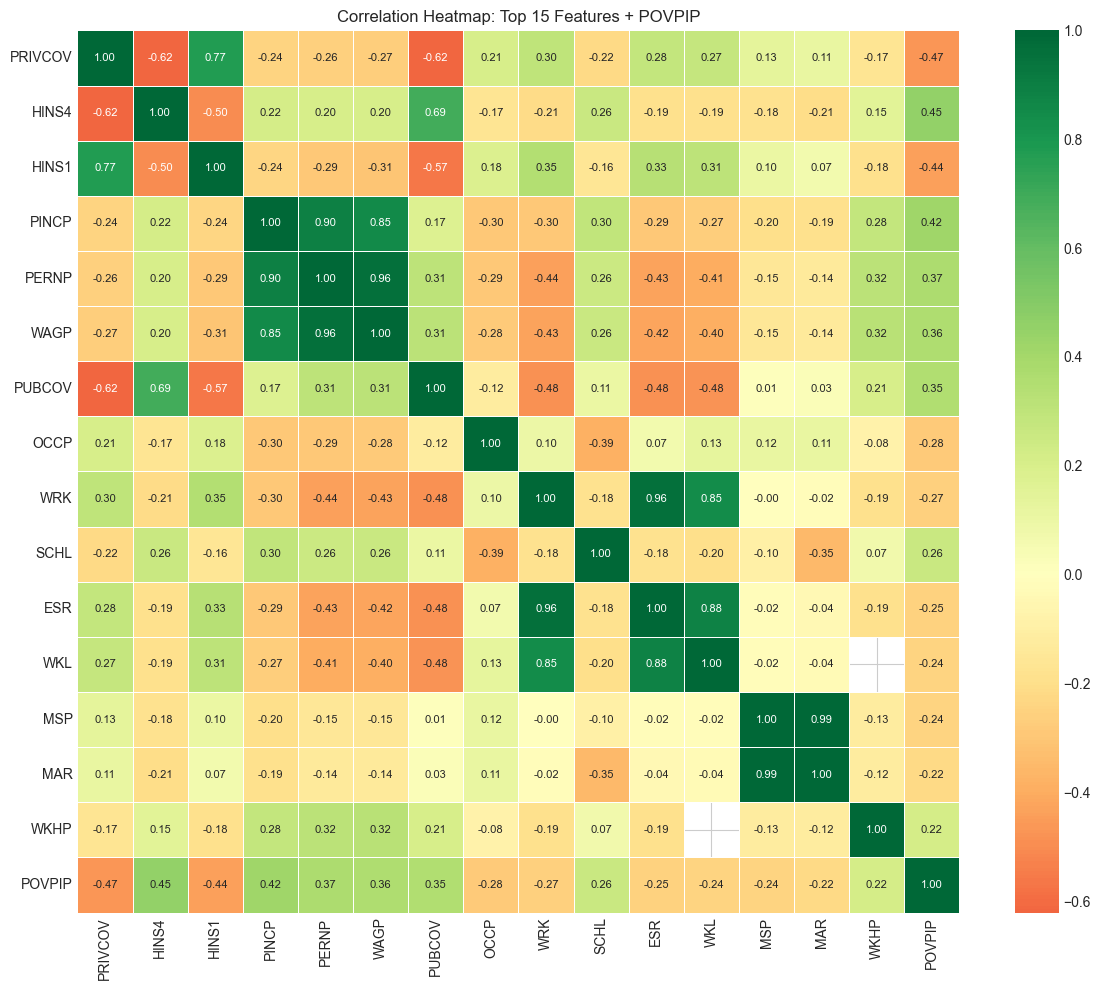

In [14]:
# Correlation heatmap for top features + POVPIP
top_features = corr_df.head(15)['column'].tolist() + ['POVPIP']

# Create correlation matrix for these features
corr_matrix = df_valid[top_features].corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, 
            fmt='.2f', linewidths=0.5, ax=ax,
            annot_kws={'size': 8})
ax.set_title('Correlation Heatmap: Top 15 Features + POVPIP')
plt.tight_layout()
plt.savefig('EDA_data/correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## Variance Analysis

Features with very low variance don't provide much discriminative power. We'll identify features with:
- Near-zero variance (most values are the same)
- Highly skewed distributions

These features are candidates for removal to reduce dimensionality.

=== Low Variance Features (mode > 95% of values) ===
Found 19 features with extremely low variance:
      column    mode_pct  unique_values
0   DIVISION  100.000000              1
2     REGION  100.000000              1
76     RACNH   99.770075              2
20     HINS7   99.582931              2
78     RACPI   99.439241              2
24     MARHD   99.122706              2
27     MARHW   99.105267              2
19     HINS6   98.248134              2
25     MARHM   97.690375              2
18     HINS5   97.671559              2
9       DEYE   97.637180              2
73   RACAIAN   96.893114              2
8       DEAR   96.405677              2
7       DDRS   96.386947              2
13       GCL   95.834260              2
35      NWRE   95.400196              3
66     POWSP   99.568432             58
37       PAP   98.157733            313
43      SSIP   96.597136            237


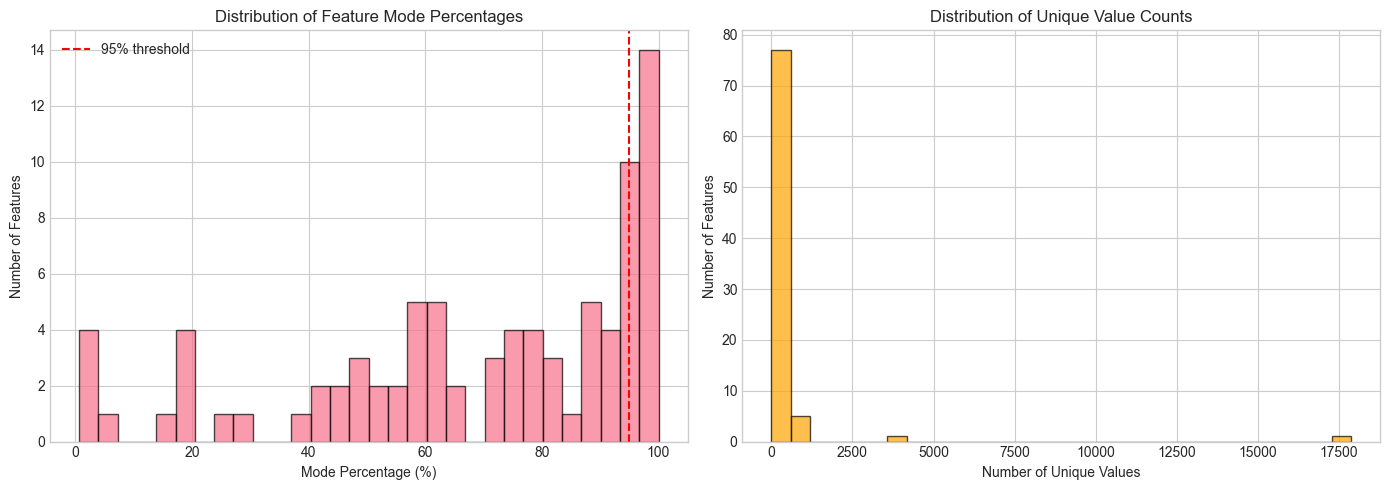

In [15]:
# Variance analysis for numeric features
variance_stats = []

for col in feature_cols:
    if col in df.columns:
        col_data = df[col].dropna()
        if len(col_data) > 0:
            variance_stats.append({
                'column': col,
                'variance': col_data.var(),
                'std': col_data.std(),
                'unique_values': col_data.nunique(),
                'mode_pct': col_data.value_counts(normalize=True).iloc[0] * 100 if len(col_data) > 0 else 0,
                'non_null_count': len(col_data)
            })

variance_df = pd.DataFrame(variance_stats)
variance_df = variance_df.sort_values('variance', ascending=True)

# Low variance features (mode > 95%)
low_var_features = variance_df[variance_df['mode_pct'] > 95]
print(f"=== Low Variance Features (mode > 95% of values) ===")
print(f"Found {len(low_var_features)} features with extremely low variance:")
print(low_var_features[['column', 'mode_pct', 'unique_values']].to_string())

# Visualize variance distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of mode percentages
axes[0].hist(variance_df['mode_pct'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(x=95, color='red', linestyle='--', label='95% threshold')
axes[0].set_xlabel('Mode Percentage (%)')
axes[0].set_ylabel('Number of Features')
axes[0].set_title('Distribution of Feature Mode Percentages')
axes[0].legend()

# Number of unique values per feature
axes[1].hist(variance_df['unique_values'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Number of Unique Values')
axes[1].set_ylabel('Number of Features')
axes[1].set_title('Distribution of Unique Value Counts')

plt.tight_layout()
plt.savefig('EDA_data/variance_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## Poverty Analysis by Key Demographics

Exploring how poverty rates vary across key demographic and socioeconomic factors.

/var/folders/7w/j0bpp7hx3pbcmhhkspmsyjx40000gp/T/ipykernel_35057/4210908526.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  poverty_by_age = df_analysis.groupby(['age_group', 'poverty_class']).size().unstack(fill_value=0)


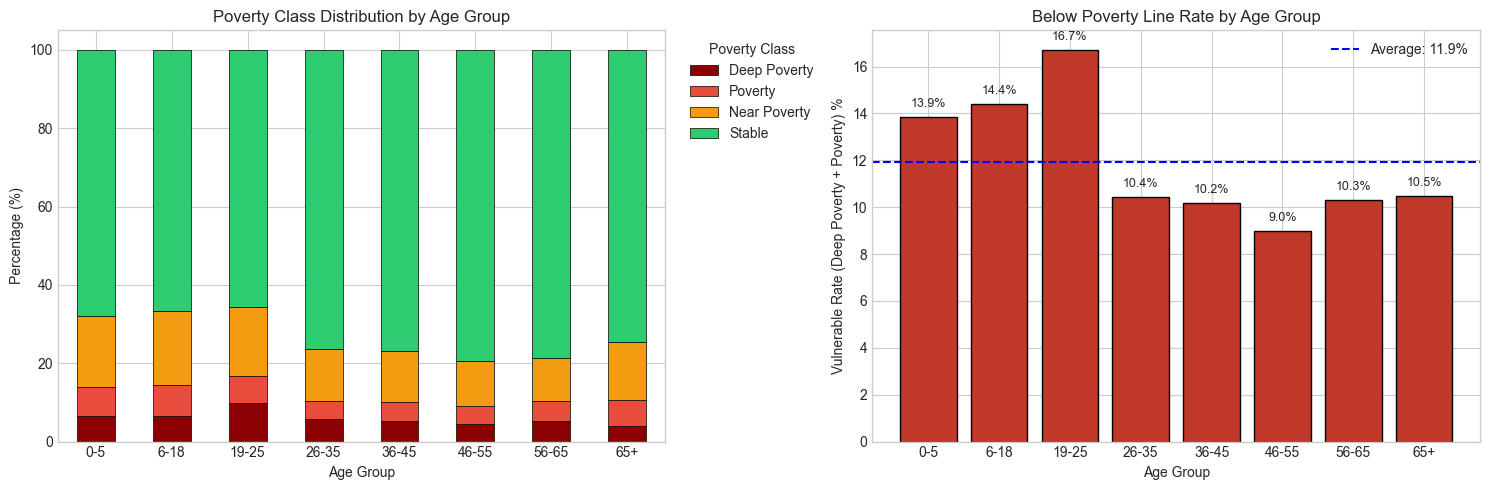


Poverty Class Distribution by Age Group (%):
poverty_class  Deep Poverty  Poverty  Near Poverty  Stable
age_group                                                 
0-5                     6.4      7.5          18.1    68.1
6-18                    6.5      7.9          18.8    66.7
19-25                   9.8      7.0          17.6    65.7
26-35                   5.7      4.7          13.2    76.4
36-45                   5.2      5.0          13.0    76.8
46-55                   4.6      4.4          11.6    79.4
56-65                   5.2      5.1          11.1    78.6
65+                     4.1      6.4          14.9    74.6


In [16]:
# Poverty Class Distribution by Age Groups
df_analysis = df[df['poverty_class'].notna()].copy()

# Create age groups
df_analysis['age_group'] = pd.cut(df_analysis['AGEP'], 
                                   bins=[0, 5, 18, 25, 35, 45, 55, 65, 100],
                                   labels=['0-5', '6-18', '19-25', '26-35', '36-45', '46-55', '56-65', '65+'])

# Calculate distribution of poverty classes by age group
class_order = ['Deep Poverty', 'Poverty', 'Near Poverty', 'Stable']
class_colors = {'Deep Poverty': '#8B0000', 'Poverty': '#e74c3c', 'Near Poverty': '#f39c12', 'Stable': '#2ecc71'}

poverty_by_age = df_analysis.groupby(['age_group', 'poverty_class']).size().unstack(fill_value=0)
poverty_by_age = poverty_by_age[class_order]  # Reorder columns
poverty_by_age_pct = poverty_by_age.div(poverty_by_age.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Stacked bar chart showing poverty class distribution by age
poverty_by_age_pct.plot(kind='bar', stacked=True, ax=axes[0], 
                        color=[class_colors[c] for c in class_order], edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_title('Poverty Class Distribution by Age Group')
axes[0].legend(title='Poverty Class', bbox_to_anchor=(1.02, 1), loc='upper left')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Deep Poverty + Poverty rate (vulnerable population) by age
vulnerable_rate = (poverty_by_age[['Deep Poverty', 'Poverty']].sum(axis=1) / 
                   poverty_by_age.sum(axis=1) * 100)
bars = axes[1].bar(vulnerable_rate.index.astype(str), vulnerable_rate.values, 
                   color='#c0392b', edgecolor='black')
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Vulnerable Rate (Deep Poverty + Poverty) %')
axes[1].set_title('Below Poverty Line Rate by Age Group')
axes[1].axhline(y=vulnerable_rate.mean(), color='blue', linestyle='--', label=f'Average: {vulnerable_rate.mean():.1f}%')
axes[1].legend()
for bar, rate in zip(bars, vulnerable_rate.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
                 f'{rate:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('EDA_data/poverty_class_by_age.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPoverty Class Distribution by Age Group (%):")
print(poverty_by_age_pct.round(1).to_string())

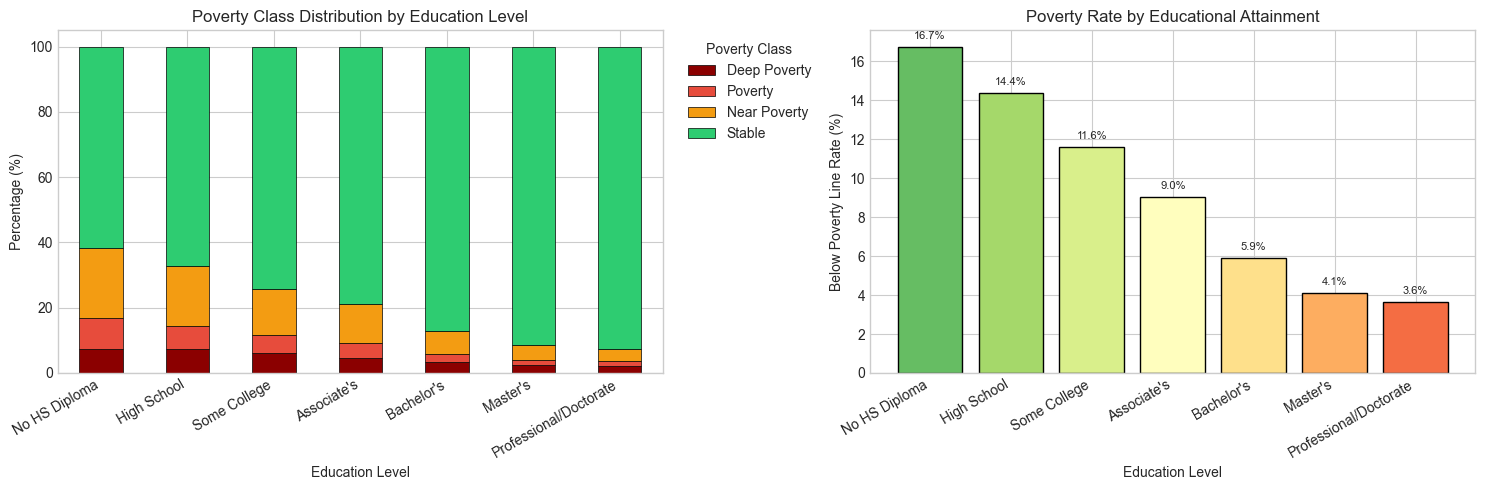


Poverty Class Distribution by Education Level (%):
poverty_class           Deep Poverty  Poverty  Near Poverty  Stable
education                                                          
No HS Diploma                    7.5      9.3          21.5    61.8
High School                      7.2      7.1          18.4    67.2
Some College                     6.1      5.5          14.2    74.2
Associate's                      4.5      4.5          12.0    78.9
Bachelor's                       3.3      2.6           7.1    87.0
Master's                         2.3      1.8           4.5    91.4
Professional/Doctorate           2.1      1.5           3.8    92.5


In [17]:
# Poverty Class Distribution by Education Level (SCHL - Educational Attainment)
# SCHL values: 1-15 = no high school diploma, 16-17 = high school, 18-19 = some college, 
# 20 = Associate's, 21 = Bachelor's, 22 = Master's, 23 = Professional, 24 = Doctorate

edu_mapping = {
    'No HS Diploma': list(range(1, 16)),
    'High School': [16, 17],
    'Some College': [18, 19],
    "Associate's": [20],
    "Bachelor's": [21],
    "Master's": [22],
    'Professional/Doctorate': [23, 24]
}

def map_education(schl):
    if pd.isna(schl):
        return None
    for label, values in edu_mapping.items():
        if int(schl) in values:
            return label
    return None

df_analysis['education'] = df_analysis['SCHL'].apply(map_education)

# Calculate poverty class distribution by education
edu_order = ['No HS Diploma', 'High School', 'Some College', "Associate's", "Bachelor's", "Master's", 'Professional/Doctorate']
class_order = ['Deep Poverty', 'Poverty', 'Near Poverty', 'Stable']
class_colors = {'Deep Poverty': '#8B0000', 'Poverty': '#e74c3c', 'Near Poverty': '#f39c12', 'Stable': '#2ecc71'}

poverty_by_edu = df_analysis.dropna(subset=['education']).groupby(['education', 'poverty_class']).size().unstack(fill_value=0)
poverty_by_edu = poverty_by_edu.reindex(edu_order)[class_order]
poverty_by_edu_pct = poverty_by_edu.div(poverty_by_edu.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Stacked bar chart
poverty_by_edu_pct.plot(kind='bar', stacked=True, ax=axes[0],
                        color=[class_colors[c] for c in class_order], edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Education Level')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_title('Poverty Class Distribution by Education Level')
axes[0].legend(title='Poverty Class', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=30, ha='right')

# Vulnerable rate (Deep Poverty + Poverty) by education
vulnerable_rate = (poverty_by_edu[['Deep Poverty', 'Poverty']].sum(axis=1) / 
                   poverty_by_edu.sum(axis=1) * 100)
colors_gradient = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(vulnerable_rate)))
bars = axes[1].bar(range(len(vulnerable_rate)), vulnerable_rate.values, color=colors_gradient, edgecolor='black')
axes[1].set_xticks(range(len(vulnerable_rate)))
axes[1].set_xticklabels(edu_order, rotation=30, ha='right')
axes[1].set_xlabel('Education Level')
axes[1].set_ylabel('Below Poverty Line Rate (%)')
axes[1].set_title('Poverty Rate by Educational Attainment')
for bar, rate in zip(bars, vulnerable_rate.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
                 f'{rate:.1f}%', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('EDA_data/poverty_class_by_education.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPoverty Class Distribution by Education Level (%):")
print(poverty_by_edu_pct.round(1).to_string())

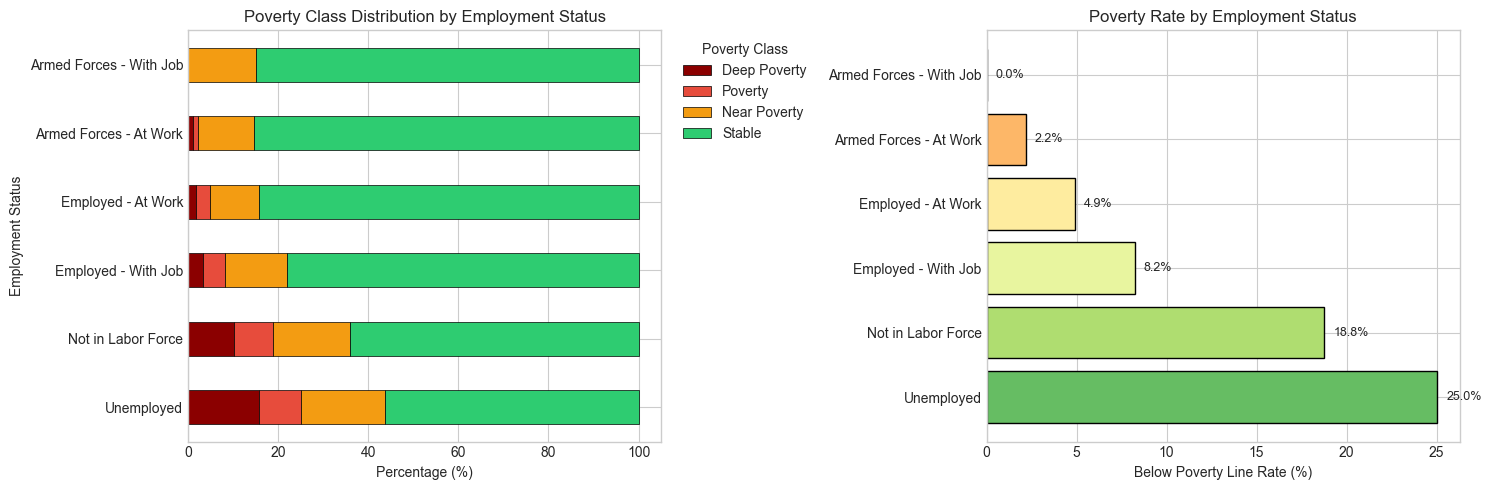


Poverty Class Distribution by Employment Status (%):
poverty_class            Deep Poverty  Poverty  Near Poverty  Stable
employment                                                          
Unemployed                       15.8      9.2          18.8    56.2
Not in Labor Force               10.2      8.6          17.2    64.0
Employed - With Job               3.4      4.8          13.7    78.1
Employed - At Work                1.7      3.2          10.8    84.2
Armed Forces - At Work            1.1      1.0          12.5    85.4
Armed Forces - With Job           0.0      0.0          15.0    85.0


In [18]:
# Poverty Class Distribution by Employment Status (ESR - Employment Status Recode)
esr_mapping = {
    1: 'Employed - At Work',
    2: 'Employed - With Job',
    3: 'Unemployed',
    4: 'Armed Forces - At Work',
    5: 'Armed Forces - With Job',
    6: 'Not in Labor Force'
}

df_analysis['employment'] = df_analysis['ESR'].map(esr_mapping)

# Calculate poverty class distribution by employment
class_order = ['Deep Poverty', 'Poverty', 'Near Poverty', 'Stable']
class_colors = {'Deep Poverty': '#8B0000', 'Poverty': '#e74c3c', 'Near Poverty': '#f39c12', 'Stable': '#2ecc71'}

poverty_by_emp = df_analysis.dropna(subset=['employment']).groupby(['employment', 'poverty_class']).size().unstack(fill_value=0)
poverty_by_emp = poverty_by_emp[class_order]
poverty_by_emp_pct = poverty_by_emp.div(poverty_by_emp.sum(axis=1), axis=0) * 100

# Sort by vulnerable rate (deep poverty + poverty)
vulnerable_rate = (poverty_by_emp[['Deep Poverty', 'Poverty']].sum(axis=1) / 
                   poverty_by_emp.sum(axis=1) * 100)
emp_order = vulnerable_rate.sort_values(ascending=False).index
poverty_by_emp_pct = poverty_by_emp_pct.reindex(emp_order)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Stacked horizontal bar chart
poverty_by_emp_pct.plot(kind='barh', stacked=True, ax=axes[0],
                        color=[class_colors[c] for c in class_order], edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Percentage (%)')
axes[0].set_ylabel('Employment Status')
axes[0].set_title('Poverty Class Distribution by Employment Status')
axes[0].legend(title='Poverty Class', bbox_to_anchor=(1.02, 1), loc='upper left')

# Vulnerable rate comparison
vulnerable_sorted = vulnerable_rate.reindex(emp_order)
colors_gradient = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(vulnerable_sorted)))
bars = axes[1].barh(range(len(vulnerable_sorted)), vulnerable_sorted.values, color=colors_gradient, edgecolor='black')
axes[1].set_yticks(range(len(vulnerable_sorted)))
axes[1].set_yticklabels(emp_order)
axes[1].set_xlabel('Below Poverty Line Rate (%)')
axes[1].set_title('Poverty Rate by Employment Status')
for bar, rate in zip(bars, vulnerable_sorted.values):
    axes[1].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                 f'{rate:.1f}%', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('EDA_data/poverty_class_by_employment.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPoverty Class Distribution by Employment Status (%):")
print(poverty_by_emp_pct.round(1).to_string())

In [19]:
#FYI
#In US Census and labor force statistics (such as the Current Population Survey), both "at work" and "with a job but not at work" are subsets of the employed population. The key difference lies in whether the person physically performed any work during the specific "reference week" (the week before the survey). 
#At Work: Individuals who worked at least one hour for pay or profit during the reference week, including those in their own business, profession, or farm.
#With a Job but Not at Work: Individuals who have a job or business but did not work at all during the reference week due to temporary absences, such as vacation, illness, bad weather, childcare problems, or labor-management disputes. 

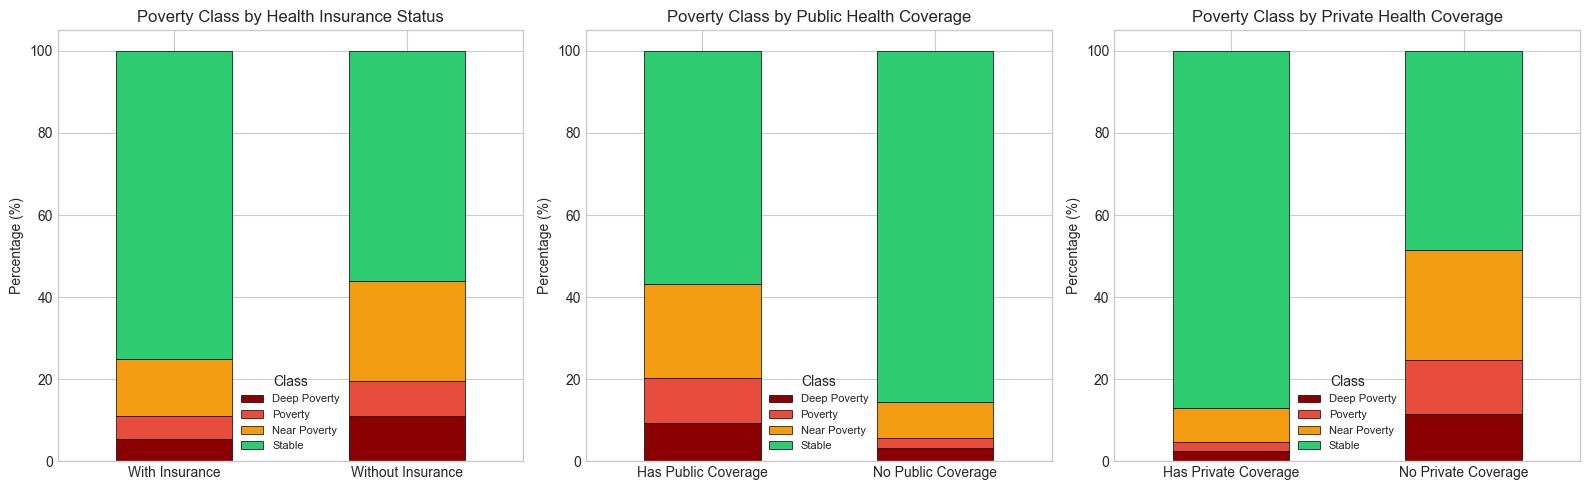


Poverty Class by Insurance Type (% distribution):

Health Insurance Status:
poverty_class      Deep Poverty  Poverty  Near Poverty  Stable
health_insurance                                              
With Insurance              5.3      5.7          13.8    75.2
Without Insurance          11.0      8.6          24.2    56.1

Public Coverage:
poverty_class        Deep Poverty  Poverty  Near Poverty  Stable
public_coverage                                                 
Has Public Coverage           9.2     11.1          22.7    56.9
No Public Coverage            3.2      2.4           8.9    85.5

Private Coverage:
poverty_class         Deep Poverty  Poverty  Near Poverty  Stable
private_coverage                                                 
Has Private Coverage           2.6      2.2           8.2    87.1
No Private Coverage           11.6     13.1          26.7    48.6


In [20]:
# Poverty Class Distribution by Health Insurance Status
# HICOV: 1 = With health insurance, 2 = Without health insurance
hicov_mapping = {1: 'With Insurance', 2: 'Without Insurance'}
df_analysis['health_insurance'] = df_analysis['HICOV'].map(hicov_mapping)

# Also look at public vs private coverage
df_analysis['public_coverage'] = df_analysis['PUBCOV'].map({1: 'Has Public Coverage', 2: 'No Public Coverage'})
df_analysis['private_coverage'] = df_analysis['PRIVCOV'].map({1: 'Has Private Coverage', 2: 'No Private Coverage'})

class_order = ['Deep Poverty', 'Poverty', 'Near Poverty', 'Stable']
class_colors = {'Deep Poverty': '#8B0000', 'Poverty': '#e74c3c', 'Near Poverty': '#f39c12', 'Stable': '#2ecc71'}

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Health insurance coverage - stacked bar
ins_dist = df_analysis.dropna(subset=['health_insurance']).groupby(['health_insurance', 'poverty_class']).size().unstack(fill_value=0)
ins_dist = ins_dist[class_order]
ins_dist_pct = ins_dist.div(ins_dist.sum(axis=1), axis=0) * 100
ins_dist_pct.plot(kind='bar', stacked=True, ax=axes[0],
                  color=[class_colors[c] for c in class_order], edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_title('Poverty Class by Health Insurance Status')
axes[0].legend(title='Class', fontsize=8)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# 2. Public coverage - stacked bar
pub_dist = df_analysis.dropna(subset=['public_coverage']).groupby(['public_coverage', 'poverty_class']).size().unstack(fill_value=0)
pub_dist = pub_dist[class_order]
pub_dist_pct = pub_dist.div(pub_dist.sum(axis=1), axis=0) * 100
pub_dist_pct.plot(kind='bar', stacked=True, ax=axes[1],
                  color=[class_colors[c] for c in class_order], edgecolor='black', linewidth=0.5)
axes[1].set_xlabel('')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_title('Poverty Class by Public Health Coverage')
axes[1].legend(title='Class', fontsize=8)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

# 3. Private coverage - stacked bar
priv_dist = df_analysis.dropna(subset=['private_coverage']).groupby(['private_coverage', 'poverty_class']).size().unstack(fill_value=0)
priv_dist = priv_dist[class_order]
priv_dist_pct = priv_dist.div(priv_dist.sum(axis=1), axis=0) * 100
priv_dist_pct.plot(kind='bar', stacked=True, ax=axes[2],
                   color=[class_colors[c] for c in class_order], edgecolor='black', linewidth=0.5)
axes[2].set_xlabel('')
axes[2].set_ylabel('Percentage (%)')
axes[2].set_title('Poverty Class by Private Health Coverage')
axes[2].legend(title='Class', fontsize=8)
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('EDA_data/poverty_class_by_health_insurance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPoverty Class by Insurance Type (% distribution):")
print("\nHealth Insurance Status:")
print(ins_dist_pct.round(1).to_string())
print("\nPublic Coverage:")
print(pub_dist_pct.round(1).to_string())
print("\nPrivate Coverage:")
print(priv_dist_pct.round(1).to_string())

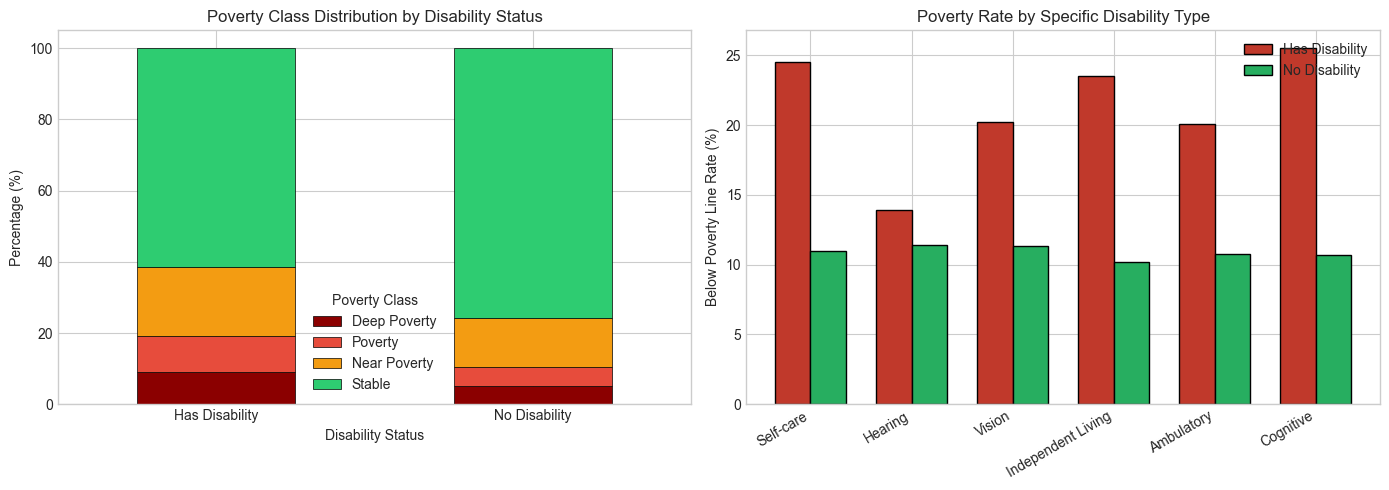


Poverty Class Distribution by Disability Status (%):
poverty_class   Deep Poverty  Poverty  Near Poverty  Stable
disability                                                 
Has Disability           9.0     10.2          19.3    61.5
No Disability            5.1      5.3          13.8    75.8


Below Poverty Line Rate by Disability Type:
   Disability Type  Has Disability  No Disability
         Self-care       24.499820      10.991977
           Hearing       13.883831      11.421757
            Vision       20.198434      11.310903
Independent Living       23.518756      10.195412
        Ambulatory       20.062404      10.791833
         Cognitive       25.499766      10.659246


In [21]:
# Poverty Class Distribution by Disability Status
dis_mapping = {1: 'Has Disability', 2: 'No Disability'}
df_analysis['disability'] = df_analysis['DIS'].map(dis_mapping)

class_order = ['Deep Poverty', 'Poverty', 'Near Poverty', 'Stable']
class_colors = {'Deep Poverty': '#8B0000', 'Poverty': '#e74c3c', 'Near Poverty': '#f39c12', 'Stable': '#2ecc71'}

# Calculate poverty class distribution by disability
dis_dist = df_analysis.dropna(subset=['disability']).groupby(['disability', 'poverty_class']).size().unstack(fill_value=0)
dis_dist = dis_dist[class_order]
dis_dist_pct = dis_dist.div(dis_dist.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar by disability status
dis_dist_pct.plot(kind='bar', stacked=True, ax=axes[0],
                  color=[class_colors[c] for c in class_order], edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Disability Status')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_title('Poverty Class Distribution by Disability Status')
axes[0].legend(title='Poverty Class')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Individual disability types - vulnerable rate comparison
disability_cols = ['DDRS', 'DEAR', 'DEYE', 'DOUT', 'DPHY', 'DREM']
disability_labels = ['Self-care', 'Hearing', 'Vision', 'Independent Living', 'Ambulatory', 'Cognitive']

disability_vuln_rates = []
for col, label in zip(disability_cols, disability_labels):
    has_dis_data = df_analysis[df_analysis[col] == 1]
    no_dis_data = df_analysis[df_analysis[col] == 2]
    
    has_dis_vuln = has_dis_data['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
    no_dis_vuln = no_dis_data['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
    
    disability_vuln_rates.append({
        'Disability Type': label, 
        'Has Disability': has_dis_vuln, 
        'No Disability': no_dis_vuln
    })

dis_df = pd.DataFrame(disability_vuln_rates)

x = np.arange(len(dis_df))
width = 0.35
bars1 = axes[1].bar(x - width/2, dis_df['Has Disability'], width, label='Has Disability', color='#c0392b', edgecolor='black')
bars2 = axes[1].bar(x + width/2, dis_df['No Disability'], width, label='No Disability', color='#27ae60', edgecolor='black')
axes[1].set_xticks(x)
axes[1].set_xticklabels(dis_df['Disability Type'], rotation=30, ha='right')
axes[1].set_ylabel('Below Poverty Line Rate (%)')
axes[1].set_title('Poverty Rate by Specific Disability Type')
axes[1].legend()

plt.tight_layout()
plt.savefig('EDA_data/poverty_class_by_disability.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPoverty Class Distribution by Disability Status (%):")
print(dis_dist_pct.round(1).to_string())
print("\n\nBelow Poverty Line Rate by Disability Type:")
print(dis_df.to_string(index=False))

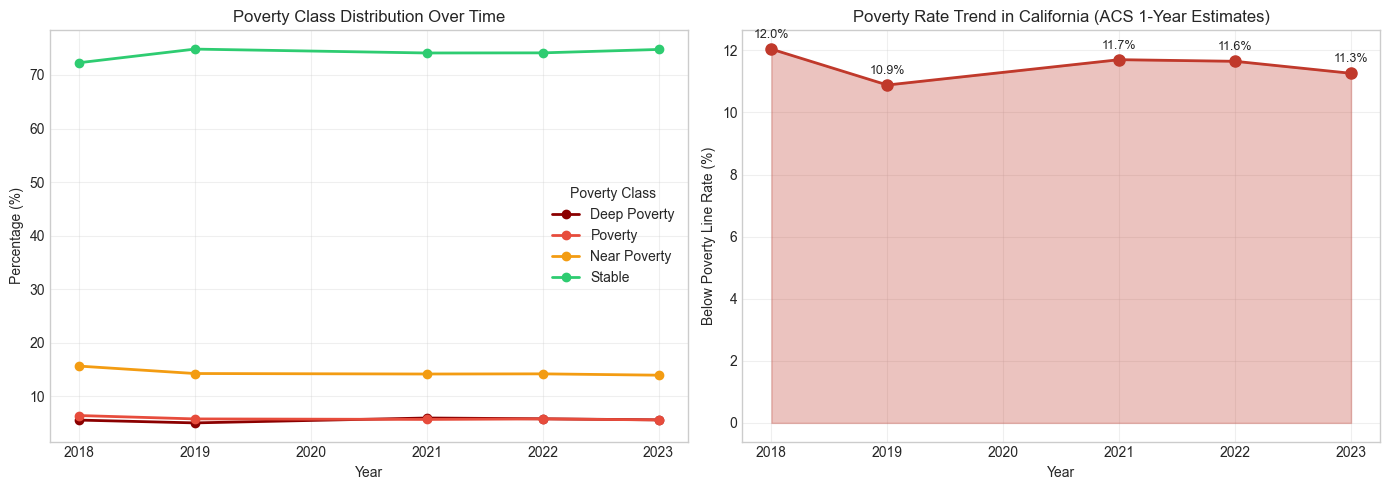


Poverty Class Distribution by Year (%):
poverty_class  Deep Poverty  Poverty  Near Poverty  Stable
year                                                      
2018                    5.6      6.4          15.7    72.3
2019                    5.1      5.8          14.3    74.8
2021                    6.0      5.7          14.2    74.1
2022                    5.8      5.8          14.2    74.1
2023                    5.6      5.6          14.0    74.8

Below Poverty Line Rate by Year:
  2018: 12.04%
  2019: 10.89%
  2021: 11.70%
  2022: 11.65%
  2023: 11.26%


In [22]:
# Poverty Class Trends Over Time (by Year)
class_order = ['Deep Poverty', 'Poverty', 'Near Poverty', 'Stable']
class_colors = {'Deep Poverty': '#8B0000', 'Poverty': '#e74c3c', 'Near Poverty': '#f39c12', 'Stable': '#2ecc71'}

# Calculate poverty class distribution by year
poverty_by_year = df_analysis.groupby(['year', 'poverty_class']).size().unstack(fill_value=0)
poverty_by_year = poverty_by_year[class_order]
poverty_by_year_pct = poverty_by_year.div(poverty_by_year.sum(axis=1), axis=0) * 100

# Vulnerable rate (Deep Poverty + Poverty) by year
vulnerable_by_year = (poverty_by_year[['Deep Poverty', 'Poverty']].sum(axis=1) / 
                      poverty_by_year.sum(axis=1) * 100)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Line chart of each poverty class over time
for cls in class_order:
    axes[0].plot(poverty_by_year_pct.index, poverty_by_year_pct[cls], 
                 marker='o', linewidth=2, markersize=6, color=class_colors[cls], label=cls)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_title('Poverty Class Distribution Over Time')
axes[0].legend(title='Poverty Class')
axes[0].grid(True, alpha=0.3)

# Vulnerable rate trend
axes[1].plot(vulnerable_by_year.index, vulnerable_by_year.values, 
             marker='o', linewidth=2, markersize=8, color='#c0392b')
axes[1].fill_between(vulnerable_by_year.index, vulnerable_by_year.values, alpha=0.3, color='#c0392b')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Below Poverty Line Rate (%)')
axes[1].set_title('Poverty Rate Trend in California (ACS 1-Year Estimates)')
axes[1].grid(True, alpha=0.3)
for yr, rate in zip(vulnerable_by_year.index, vulnerable_by_year.values):
    axes[1].annotate(f'{rate:.1f}%', (yr, rate), textcoords="offset points", 
                     xytext=(0, 8), ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('EDA_data/poverty_class_by_year.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPoverty Class Distribution by Year (%):")
print(poverty_by_year_pct.round(1).to_string())
print(f"\nBelow Poverty Line Rate by Year:")
for yr, rate in vulnerable_by_year.items():
    print(f"  {yr}: {rate:.2f}%")

## Feature Reduction Recommendations

Based on our analysis, we'll identify features to keep and features to drop based on:
1. **Avoid Data Leakage** - Remove ALL income variables (PINCP, PERNP, WAGP, RETP, etc.) since we're predicting poverty from non-income risk factors
2. **Correlation with POVPIP** - Keep features with |correlation| >= 0.08
3. **Variance** - Drop features with very low variance (mode >95%)
4. **Use Summary Recodes Only** - Keep DIS (not individual disabilities), HICOV (not HINS1-7), ESR (not NWLK/NWLA) to avoid multicollinearity
5. **Simplify Race Variables** - Keep only RAC1P + HISP, drop redundant binary race flags

In [23]:
# Feature Selection Strategy

# 1. INCOME FEATURES TO EXCLUDE (Data Leakage)
# All income variables are used to calculate POVPIP - including them defeats the purpose
income_features = ['PINCP', 'PERNP', 'WAGP', 'SEMP', 'INTP', 'RETP', 'SSP', 'SSIP', 'PAP', 'OIP']
print("=== Features to EXCLUDE (Income - Data Leakage) ===")
print("These are directly related to income, which determines POVPIP:")
for f in income_features:
    if f in corr_df['column'].values:
        row = corr_df[corr_df['column'] == f].iloc[0]
        print(f"  {f:8} | r={row['correlation']:+.3f} | {row['short_label']}")

# 2. DETAILED FEATURES TO EXCLUDE (Use Summary Recodes Instead)
# These create multicollinearity - the summary recodes capture the same info
detailed_to_exclude = [
    # Individual disabilities (use DIS instead)
    'DDRS', 'DEAR', 'DEYE', 'DOUT', 'DPHY', 'DREM',
    # Individual insurance types (use HICOV, PRIVCOV, PUBCOV instead)
    'HINS1', 'HINS2', 'HINS3', 'HINS4', 'HINS5', 'HINS6', 'HINS7',
    # Raw employment variables (use ESR instead)
    'NWLK', 'NWLA', 'NWAB', 'NWAV', 'NWRE',
    # Redundant race variables (use RAC1P + HISP instead)
    'RACWHT', 'RACASN', 'RACSOR', 'RACBLK', 'RACNH', 'RACPI', 'RACAIAN', 'RAC2P', 'RAC3P', 'ANC', 'ANC1P', 'ANC2P', 'RACNUM'
]
print(f"\n=== Features to EXCLUDE (Redundant/Detailed - Use Summaries) ===")
print("Using summary recodes instead to avoid multicollinearity:")
print(f"  Disability: Use DIS, not {[x for x in detailed_to_exclude if x.startswith('D') and x != 'DIS']}")
print(f"  Insurance: Use HICOV/PRIVCOV/PUBCOV, not HINS1-7")
print(f"  Employment: Use ESR, not NWLK/NWLA/etc.")
print(f"  Race: Use RAC1P + HISP, not binary race flags")

# 3. Identify features with meaningful correlation (|r| >= 0.08)
min_corr = 0.08
all_exclusions = set(income_features + detailed_to_exclude)
high_corr_features = corr_df[corr_df['abs_corr'] >= min_corr]['column'].tolist()
high_corr_features = [f for f in high_corr_features if f not in all_exclusions]

print(f"\n=== Features with |correlation| >= {min_corr} (after exclusions): {len(high_corr_features)} ===")
for f in high_corr_features:
    row = corr_df[corr_df['column'] == f].iloc[0]
    print(f"  {f:12} | r={row['correlation']:+.3f} | {row['short_label']}")

# 4. Identify low variance features to drop (mode > 95%)
low_var_to_drop = variance_df[variance_df['mode_pct'] > 95]['column'].tolist()
print(f"\n=== Low Variance Features to DROP (mode > 95%): {len(low_var_to_drop)} ===")
if low_var_to_drop:
    print(low_var_to_drop)
else:
    print("  None")

=== Features to EXCLUDE (Income - Data Leakage) ===
These are directly related to income, which determines POVPIP:
  PINCP    | r=+0.416 | Total person's income (use ADJINC to adjust t...
  PERNP    | r=+0.372 | Total person's earnings (use ADJINC to adjust...
  WAGP     | r=+0.363 | Wages or salary income past 12 months (use AD...
  SEMP     | r=+0.083 | Self-employment income past 12 months (use AD...
  INTP     | r=+0.118 | Interest, dividends, and net rental income pa...
  RETP     | r=+0.165 | Retirement income past 12 months (use ADJINC ...
  SSP      | r=+0.074 | Social Security income past 12 months (use AD...
  SSIP     | r=-0.093 | Supplementary Security Income past 12 months ...
  PAP      | r=-0.050 | Public assistance income past 12 months (use ...
  OIP      | r=+0.048 | All other income past 12 months (use ADJINC t...

=== Features to EXCLUDE (Redundant/Detailed - Use Summaries) ===
Using summary recodes instead to avoid multicollinearity:
  Disability: Use DIS, not ['DD

In [24]:
# 5. Compile final recommended feature set

# Start with features that have meaningful correlation with POVPIP (already filtered)
recommended_features = set(high_corr_features)

# Remove low variance features
recommended_features = recommended_features - set(low_var_to_drop)

# Add domain-important features that might have lower correlation but are theoretically important
domain_important = ['AGEP', 'SEX', 'RAC1P', 'HISP', 'CIT', 'NATIVITY', 'MIG']
for f in domain_important:
    if f in feature_cols and f not in all_exclusions:
        recommended_features.add(f)

recommended_features = sorted(list(recommended_features))

# Group features by category for review
categories = {
    'Demographics': ['AGEP', 'SEX', 'MAR', 'MSP', 'CIT', 'NATIVITY', 'MIG', 'QTRBIR'],
    'Race/Ethnicity': ['RAC1P', 'HISP'],
    'Education': ['SCHL', 'SCH'],
    'Employment': ['ESR', 'COW', 'WRK', 'WKL', 'WKHP', 'OCCP', 'INDP', 'SOCP', 'NAICSP'],
    'Health Insurance': ['HICOV', 'PRIVCOV', 'PUBCOV'],
    'Disability': ['DIS'],
    'Geography': ['DIVISION', 'REGION', 'PUMA', 'POBP', 'POWSP', 'POWPUMA'],
    'Household': ['RC', 'OC', 'GCL', 'PAOC']
}

print(f"{'='*60}")
print(f"FINAL RECOMMENDED FEATURE SET: {len(recommended_features)} features")
print(f"{'='*60}")

for category, cols in categories.items():
    cat_features = [f for f in recommended_features if f in cols]
    if cat_features:
        print(f"\n{category} ({len(cat_features)}):")
        for f in cat_features:
            if f in corr_df['column'].values:
                row = corr_df[corr_df['column'] == f].iloc[0]
                print(f"  {f:12} | r={row['correlation']:+.3f} | {row['short_label']}")
            else:
                label_vals = df_dict[df_dict['column'] == f]['label'].values
                label = str(label_vals[0])[:45] if len(label_vals) > 0 else 'N/A'
                print(f"  {f:12} | (domain)    | {label}")

# Check for any uncategorized
all_categorized = [f for cols in categories.values() for f in cols]
uncategorized = [f for f in recommended_features if f not in all_categorized]
if uncategorized:
    print(f"\nOther ({len(uncategorized)}):")
    for f in uncategorized:
        if f in corr_df['column'].values:
            row = corr_df[corr_df['column'] == f].iloc[0]
            print(f"  {f:12} | r={row['correlation']:+.3f} | {row['short_label']}")

# 6. Verify no highly correlated pairs remain in our final set
print(f"\n{'='*60}")
print("MULTICOLLINEARITY CHECK")
print(f"{'='*60}")

numeric_recommended = [f for f in recommended_features if f in df_valid.columns]
corr_matrix_final = df_valid[numeric_recommended].corr()

high_corr_pairs = []
for i in range(len(corr_matrix_final.columns)):
    for j in range(i+1, len(corr_matrix_final.columns)):
        corr_val = corr_matrix_final.iloc[i, j]
        if abs(corr_val) > 0.80:
            high_corr_pairs.append({
                'feature1': corr_matrix_final.columns[i],
                'feature2': corr_matrix_final.columns[j],
                'correlation': corr_val
            })

if high_corr_pairs:
    print(f"\nWarning: {len(high_corr_pairs)} highly correlated pairs (|r| > 0.80):")
    for pair in high_corr_pairs:
        print(f"  {pair['feature1']} <-> {pair['feature2']}: r={pair['correlation']:.3f}")
else:
    print("\nNo highly correlated pairs (|r| > 0.80) - feature set is clean!")

FINAL RECOMMENDED FEATURE SET: 22 features

Demographics (7):
  AGEP         | r=+0.095 | Age
  CIT          | r=-0.083 | Citizenship status
  MAR          | r=-0.220 | Marital status
  MIG          | r=-0.044 | Mobility status (lived here 1 year ago)
  MSP          | r=-0.244 | Married, spouse present/spouse absent
  NATIVITY     | r=-0.068 | Nativity
  SEX          | r=-0.031 | Sex

Race/Ethnicity (2):
  HISP         | r=-0.078 | Recoded detailed Hispanic origin
  RAC1P        | r=-0.124 | Recoded detailed race code (Note: due to spac...

Education (1):
  SCHL         | r=+0.264 | Educational attainment

Employment (5):
  ESR          | r=-0.250 | Employment status recode
  OCCP         | r=-0.284 | Occupation recode for 2018 and later based on...
  WKHP         | r=+0.216 | Usual hours worked per week past 12 months
  WKL          | r=-0.245 | When last worked
  WRK          | r=-0.265 | Worked last week

Health Insurance (3):
  HICOV        | r=-0.138 | Health insurance coverage re

In [25]:
# Save recommended features with their descriptions and correlations
recommended_dict = df_dict[df_dict['column'].isin(recommended_features)][['column', 'label']].copy()

# Add correlation info
recommended_dict = recommended_dict.merge(
    corr_df[['column', 'correlation', 'abs_corr']], 
    on='column', 
    how='left'
)
recommended_dict = recommended_dict.sort_values('abs_corr', ascending=False)
recommended_dict.to_csv('EDA_data/recommended_features.csv', index=False)

print("=== Final Feature List Saved ===")
print(f"Total features: {len(recommended_features)}")
print(f"Saved to: EDA_data/recommended_features.csv")

# Summary
print("\n=== EXCLUDED FEATURES SUMMARY ===")
print(f"Income variables (leakage): {len(income_features)}")
print(f"Detailed/redundant variables: {len(detailed_to_exclude)}")
print(f"Low variance: {len(low_var_to_drop)}")

print("\n=== FINAL FEATURE COUNT BY CATEGORY ===")
for category, cols in categories.items():
    count = len([f for f in recommended_features if f in cols])
    if count > 0:
        print(f"  {category}: {count}")

=== Final Feature List Saved ===
Total features: 22
Saved to: EDA_data/recommended_features.csv

=== EXCLUDED FEATURES SUMMARY ===
Income variables (leakage): 10
Detailed/redundant variables: 31
Low variance: 19

=== FINAL FEATURE COUNT BY CATEGORY ===
  Demographics: 7
  Race/Ethnicity: 2
  Education: 1
  Employment: 5
  Health Insurance: 3
  Disability: 1
  Geography: 1
  Household: 1


## EDA Summary and Key Findings

### Target Variable (POVPIP) - Multiclass Classification
We use a 4-class classification based on income-to-poverty ratio (POVPIP):

| Class | POVPIP Range | Description |
|-------|--------------|-------------|
| **Deep Poverty** | 0-50 | Severe economic hardship, less than half the poverty threshold |
| **Poverty** | 51-100 | Below poverty line |
| **Near Poverty** | 101-200 | Above poverty line but vulnerable, limited financial buffer |
| **Stable** | 201+ | More than twice the poverty threshold, relatively secure |

### Class Distribution
- Significant class imbalance exists - "Stable" is the majority class
- Deep Poverty and Poverty combined represent approximately 11% of the population
- Near Poverty represents an important "at risk" population that may benefit from early intervention

### Feature Selection Philosophy
We focused on identifying **risk factors** that predict poverty susceptibility, NOT income proxies:

1. **Excluded ALL income variables** (PINCP, PERNP, WAGP, RETP, SSP, SSIP, PAP, etc.)
   - POVPIP is calculated from income, so including income = data leakage
   - Goal is to identify at-risk individuals using non-income factors

2. **Used Summary Recodes Only** (avoid multicollinearity)
   - DIS instead of DDRS, DEAR, DEYE, DOUT, DPHY, DREM
   - HICOV/PRIVCOV/PUBCOV instead of HINS1-7
   - ESR instead of NWLK, NWLA, NWAB

3. **Simplified Race Variables**
   - Keep RAC1P (detailed race code) + HISP (Hispanic origin)
   - Drop redundant binary flags (RACWHT, RACASN, RACSOR, etc.)

### Final Feature Categories
- **Health Insurance**: HICOV, PRIVCOV, PUBCOV - strongest predictors
- **Employment**: ESR, WRK, WKL, WKHP, OCCP
- **Education**: SCHL - educational attainment
- **Demographics**: AGEP, SEX, MAR, MSP, CIT, NATIVITY
- **Race/Ethnicity**: RAC1P, HISP
- **Disability**: DIS

### Multiclass Modeling Considerations
For model training, consider:
- **Class weights** (sklearn: `class_weight='balanced'`) to handle imbalance
- **Ordinal regression** since classes have natural ordering (Deep Poverty < Poverty < Near Poverty < Stable)
- **Metrics**: Use macro F1-score or weighted F1-score to account for class imbalance
- **Focus on recall** for poverty classes to minimize false negatives (missing at-risk individuals)
- Consider combining Deep Poverty + Poverty vs Near Poverty vs Stable for a 3-class simplified version if needed

# More Visuals

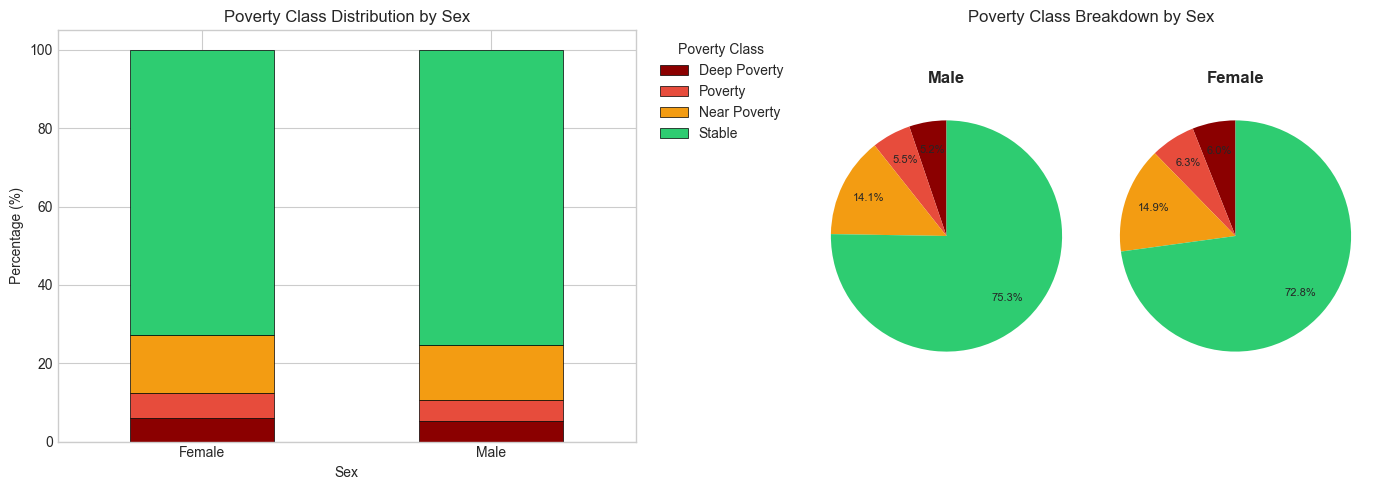


Poverty Class Distribution by Sex (%):
poverty_class  Deep Poverty  Poverty  Near Poverty  Stable
sex                                                       
Female                  6.0      6.3          14.9    72.8
Male                    5.2      5.5          14.1    75.3


In [26]:
# Poverty Class Distribution by Sex
sex_mapping = {1: 'Male', 2: 'Female'}
df_analysis['sex'] = df_analysis['SEX'].map(sex_mapping)

class_order = ['Deep Poverty', 'Poverty', 'Near Poverty', 'Stable']
class_colors = {'Deep Poverty': '#8B0000', 'Poverty': '#e74c3c', 'Near Poverty': '#f39c12', 'Stable': '#2ecc71'}

sex_dist = df_analysis.dropna(subset=['sex']).groupby(['sex', 'poverty_class']).size().unstack(fill_value=0)
sex_dist = sex_dist[class_order]
sex_dist_pct = sex_dist.div(sex_dist.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar chart
sex_dist_pct.plot(kind='bar', stacked=True, ax=axes[0],
                  color=[class_colors[c] for c in class_order], edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Sex')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_title('Poverty Class Distribution by Sex')
axes[0].legend(title='Poverty Class', bbox_to_anchor=(1.02, 1), loc='upper left')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Pie charts for each sex
for i, sex in enumerate(['Male', 'Female']):
    ax_pie = axes[1].inset_axes([i*0.5, 0, 0.5, 1])
    data = sex_dist.loc[sex]
    colors = [class_colors[c] for c in class_order]
    wedges, texts, autotexts = ax_pie.pie(data, labels=None, autopct='%1.1f%%', 
                                           colors=colors, startangle=90, pctdistance=0.75)
    ax_pie.set_title(sex, fontsize=12, fontweight='bold')
    for autotext in autotexts:
        autotext.set_fontsize(8)
axes[1].axis('off')
axes[1].set_title('Poverty Class Breakdown by Sex', fontsize=12)

plt.tight_layout()
plt.savefig('EDA_data/poverty_class_by_sex.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPoverty Class Distribution by Sex (%):")
print(sex_dist_pct.round(1).to_string())

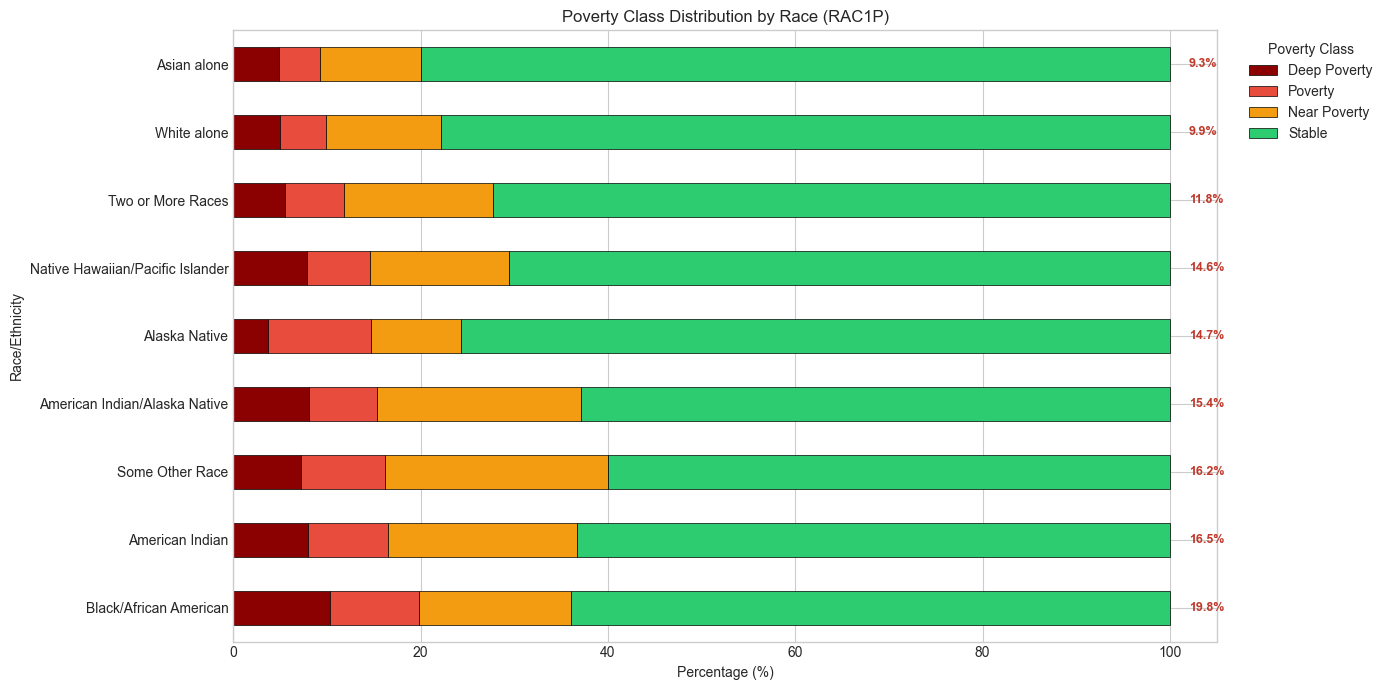


Poverty Rate by Race (Deep Poverty + Poverty %):
race
Black/African American              19.8
American Indian                     16.5
Some Other Race                     16.2
American Indian/Alaska Native       15.4
Alaska Native                       14.7
Native Hawaiian/Pacific Islander    14.6
Two or More Races                   11.8
White alone                          9.9
Asian alone                          9.3


In [27]:
# Poverty Class Distribution by Race/Ethnicity (RAC1P)
race_mapping = {
    1: 'White alone',
    2: 'Black/African American',
    3: 'American Indian',
    4: 'Alaska Native',
    5: 'American Indian/Alaska Native',
    6: 'Asian alone',
    7: 'Native Hawaiian/Pacific Islander',
    8: 'Some Other Race',
    9: 'Two or More Races'
}

df_analysis['race'] = df_analysis['RAC1P'].map(race_mapping)

# Also create Hispanic/Latino indicator
df_analysis['hispanic'] = df_analysis['HISP'].apply(lambda x: 'Hispanic/Latino' if x > 1 else 'Not Hispanic/Latino')

class_order = ['Deep Poverty', 'Poverty', 'Near Poverty', 'Stable']
class_colors = {'Deep Poverty': '#8B0000', 'Poverty': '#e74c3c', 'Near Poverty': '#f39c12', 'Stable': '#2ecc71'}

# Race distribution
race_dist = df_analysis.dropna(subset=['race']).groupby(['race', 'poverty_class']).size().unstack(fill_value=0)
race_dist = race_dist[class_order]
race_dist_pct = race_dist.div(race_dist.sum(axis=1), axis=0) * 100

# Sort by poverty rate
vulnerable_rate = (race_dist_pct['Deep Poverty'] + race_dist_pct['Poverty'])
race_dist_pct = race_dist_pct.loc[vulnerable_rate.sort_values(ascending=False).index]

fig, ax = plt.subplots(figsize=(14, 7))
race_dist_pct.plot(kind='barh', stacked=True, ax=ax,
                   color=[class_colors[c] for c in class_order], edgecolor='black', linewidth=0.5)
ax.set_xlabel('Percentage (%)')
ax.set_ylabel('Race/Ethnicity')
ax.set_title('Poverty Class Distribution by Race (RAC1P)')
ax.legend(title='Poverty Class', bbox_to_anchor=(1.02, 1), loc='upper left')

# Add vulnerable rate labels
for i, (idx, row) in enumerate(race_dist_pct.iterrows()):
    vuln = row['Deep Poverty'] + row['Poverty']
    ax.text(102, i, f'{vuln:.1f}%', va='center', fontsize=9, fontweight='bold', color='#c0392b')

plt.tight_layout()
plt.savefig('EDA_data/poverty_class_by_race.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPoverty Rate by Race (Deep Poverty + Poverty %):")
print(vulnerable_rate.sort_values(ascending=False).round(1).to_string())

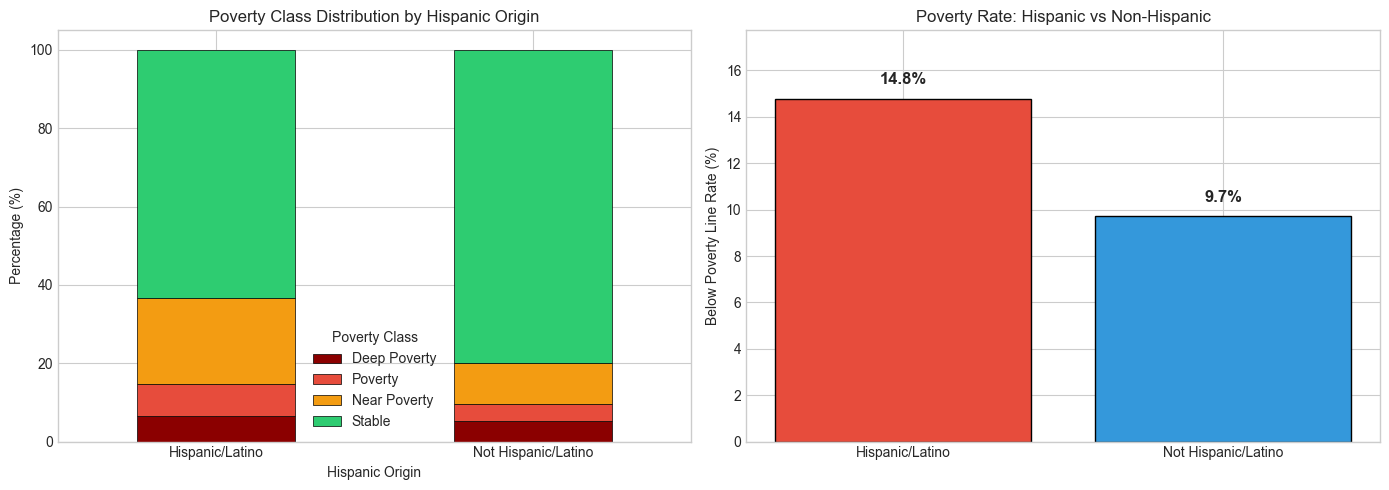


Poverty Rate Comparison:
  Hispanic/Latino: 14.8%
  Not Hispanic/Latino: 9.7%


In [28]:
# Poverty Class Distribution by Hispanic Origin
hisp_dist = df_analysis.dropna(subset=['hispanic']).groupby(['hispanic', 'poverty_class']).size().unstack(fill_value=0)
hisp_dist = hisp_dist[class_order]
hisp_dist_pct = hisp_dist.div(hisp_dist.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar chart
hisp_dist_pct.plot(kind='bar', stacked=True, ax=axes[0],
                   color=[class_colors[c] for c in class_order], edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Hispanic Origin')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_title('Poverty Class Distribution by Hispanic Origin')
axes[0].legend(title='Poverty Class')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Donut chart comparison
vulnerable_hisp = hisp_dist_pct.loc['Hispanic/Latino', ['Deep Poverty', 'Poverty']].sum()
vulnerable_non = hisp_dist_pct.loc['Not Hispanic/Latino', ['Deep Poverty', 'Poverty']].sum()

labels = ['Hispanic/Latino', 'Not Hispanic/Latino']
vuln_rates = [vulnerable_hisp, vulnerable_non]
colors_bar = ['#e74c3c', '#3498db']

bars = axes[1].bar(labels, vuln_rates, color=colors_bar, edgecolor='black')
axes[1].set_ylabel('Below Poverty Line Rate (%)')
axes[1].set_title('Poverty Rate: Hispanic vs Non-Hispanic')
axes[1].set_ylim(0, max(vuln_rates) * 1.2)

for bar, rate in zip(bars, vuln_rates):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'{rate:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('EDA_data/poverty_class_by_hispanic.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPoverty Rate Comparison:")
print(f"  Hispanic/Latino: {vulnerable_hisp:.1f}%")
print(f"  Not Hispanic/Latino: {vulnerable_non:.1f}%")

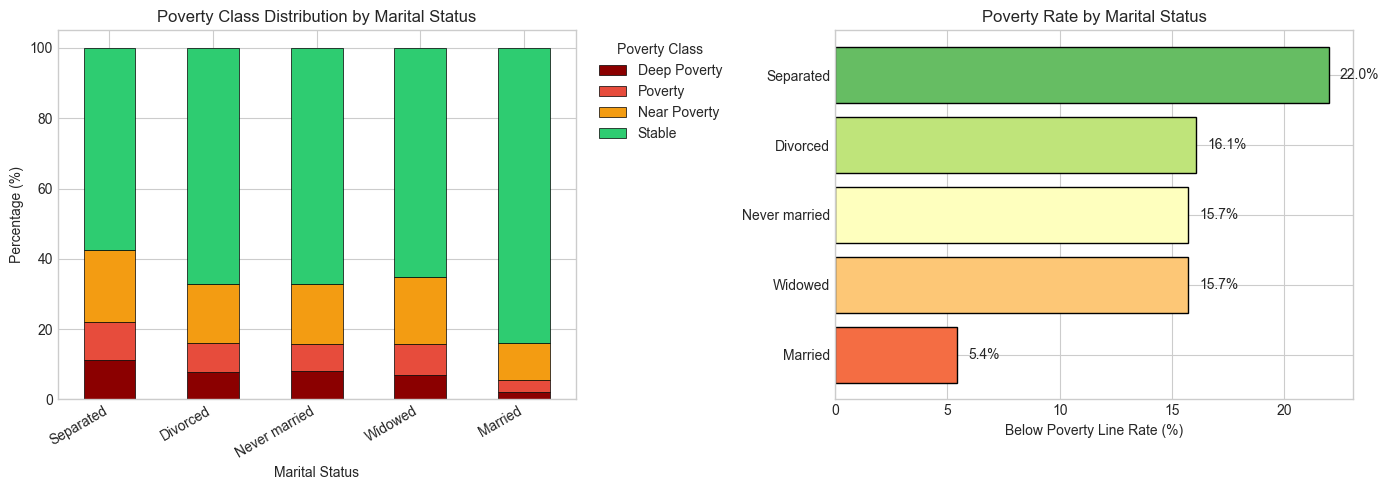


Poverty Rate by Marital Status:
marital_status
Separated        22.0
Divorced         16.1
Never married    15.7
Widowed          15.7
Married           5.4


In [29]:
# Poverty Class Distribution by Marital Status (MAR)
mar_mapping = {
    1: 'Married',
    2: 'Widowed',
    3: 'Divorced',
    4: 'Separated',
    5: 'Never married'
}

df_analysis['marital_status'] = df_analysis['MAR'].map(mar_mapping)

mar_dist = df_analysis.dropna(subset=['marital_status']).groupby(['marital_status', 'poverty_class']).size().unstack(fill_value=0)
mar_dist = mar_dist[class_order]
mar_dist_pct = mar_dist.div(mar_dist.sum(axis=1), axis=0) * 100

# Sort by poverty rate
vulnerable_rate = (mar_dist_pct['Deep Poverty'] + mar_dist_pct['Poverty'])
mar_dist_pct = mar_dist_pct.loc[vulnerable_rate.sort_values(ascending=False).index]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar chart
mar_dist_pct.plot(kind='bar', stacked=True, ax=axes[0],
                  color=[class_colors[c] for c in class_order], edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Marital Status')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_title('Poverty Class Distribution by Marital Status')
axes[0].legend(title='Poverty Class', bbox_to_anchor=(1.02, 1), loc='upper left')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=30, ha='right')

# Bar chart of vulnerable rates
vulnerable_sorted = vulnerable_rate.sort_values(ascending=True)
colors_gradient = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(vulnerable_sorted)))
bars = axes[1].barh(range(len(vulnerable_sorted)), vulnerable_sorted.values, color=colors_gradient, edgecolor='black')
axes[1].set_yticks(range(len(vulnerable_sorted)))
axes[1].set_yticklabels(vulnerable_sorted.index)
axes[1].set_xlabel('Below Poverty Line Rate (%)')
axes[1].set_title('Poverty Rate by Marital Status')
for bar, rate in zip(bars, vulnerable_sorted.values):
    axes[1].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                 f'{rate:.1f}%', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('EDA_data/poverty_class_by_marital.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPoverty Rate by Marital Status:")
print(vulnerable_rate.sort_values(ascending=False).round(1).to_string())

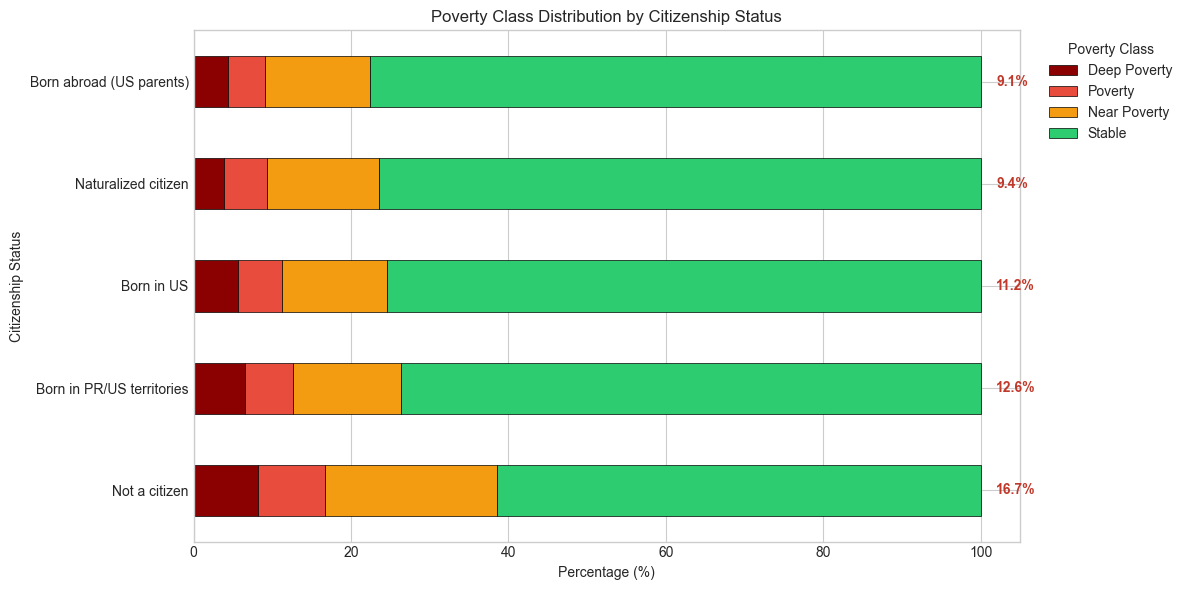


Poverty Rate by Citizenship Status:
citizenship
Not a citizen                16.7
Born in PR/US territories    12.6
Born in US                   11.2
Naturalized citizen           9.4
Born abroad (US parents)      9.1


In [30]:
# Poverty Class Distribution by Citizenship Status (CIT)
cit_mapping = {
    1: 'Born in US',
    2: 'Born in PR/US territories',
    3: 'Born abroad (US parents)',
    4: 'Naturalized citizen',
    5: 'Not a citizen'
}

df_analysis['citizenship'] = df_analysis['CIT'].map(cit_mapping)

cit_dist = df_analysis.dropna(subset=['citizenship']).groupby(['citizenship', 'poverty_class']).size().unstack(fill_value=0)
cit_dist = cit_dist[class_order]
cit_dist_pct = cit_dist.div(cit_dist.sum(axis=1), axis=0) * 100

# Sort by poverty rate
vulnerable_rate = (cit_dist_pct['Deep Poverty'] + cit_dist_pct['Poverty'])
cit_dist_pct = cit_dist_pct.loc[vulnerable_rate.sort_values(ascending=False).index]

fig, ax = plt.subplots(figsize=(12, 6))
cit_dist_pct.plot(kind='barh', stacked=True, ax=ax,
                  color=[class_colors[c] for c in class_order], edgecolor='black', linewidth=0.5)
ax.set_xlabel('Percentage (%)')
ax.set_ylabel('Citizenship Status')
ax.set_title('Poverty Class Distribution by Citizenship Status')
ax.legend(title='Poverty Class', bbox_to_anchor=(1.02, 1), loc='upper left')

# Add vulnerable rate labels
for i, (idx, row) in enumerate(cit_dist_pct.iterrows()):
    vuln = row['Deep Poverty'] + row['Poverty']
    ax.text(102, i, f'{vuln:.1f}%', va='center', fontsize=10, fontweight='bold', color='#c0392b')

plt.tight_layout()
plt.savefig('EDA_data/poverty_class_by_citizenship.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPoverty Rate by Citizenship Status:")
print(vulnerable_rate.sort_values(ascending=False).round(1).to_string())

/var/folders/7w/j0bpp7hx3pbcmhhkspmsyjx40000gp/T/ipykernel_35057/1257740523.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  intersect_data = df_adults.groupby(['adult_age_group', 'education']).apply(
/var/folders/7w/j0bpp7hx3pbcmhhkspmsyjx40000gp/T/ipykernel_35057/1257740523.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  intersect_data = df_adults.groupby(['adult_age_group', 'education']).apply(


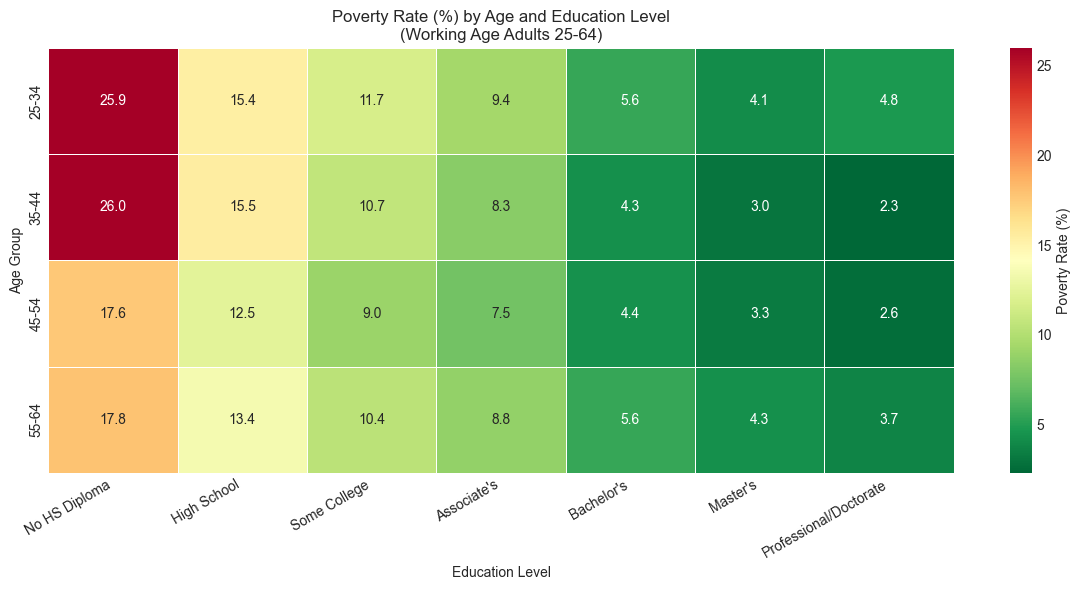


Poverty Rate by Age x Education (%):
education        No HS Diploma  High School  Some College  Associate's  Bachelor's  Master's  Professional/Doctorate
adult_age_group                                                                                                     
25-34                     25.9         15.4          11.7          9.4         5.6       4.1                     4.8
35-44                     26.0         15.5          10.7          8.3         4.3       3.0                     2.3
45-54                     17.6         12.5           9.0          7.5         4.4       3.3                     2.6
55-64                     17.8         13.4          10.4          8.8         5.6       4.3                     3.7


In [31]:
# Intersectional Analysis: Age Group x Education Level
# Create heatmap of poverty rates

# Filter for adults only (working age)
df_adults = df_analysis[(df_analysis['AGEP'] >= 25) & (df_analysis['AGEP'] <= 64)].copy()

# Create simplified age groups for adults
df_adults['adult_age_group'] = pd.cut(df_adults['AGEP'], 
                                       bins=[24, 34, 44, 54, 64],
                                       labels=['25-34', '35-44', '45-54', '55-64'])

# Calculate poverty rate for each intersection
intersect_data = df_adults.groupby(['adult_age_group', 'education']).apply(
    lambda x: (x['poverty_class'].isin(['Deep Poverty', 'Poverty'])).mean() * 100
).unstack()

# Reorder education
edu_order = ['No HS Diploma', 'High School', 'Some College', "Associate's", "Bachelor's", "Master's", 'Professional/Doctorate']
intersect_data = intersect_data[[c for c in edu_order if c in intersect_data.columns]]

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(intersect_data, annot=True, fmt='.1f', cmap='RdYlGn_r', 
            linewidths=0.5, ax=ax, cbar_kws={'label': 'Poverty Rate (%)'})
ax.set_xlabel('Education Level')
ax.set_ylabel('Age Group')
ax.set_title('Poverty Rate (%) by Age and Education Level\n(Working Age Adults 25-64)')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.savefig('EDA_data/poverty_heatmap_age_education.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPoverty Rate by Age x Education (%):")
print(intersect_data.round(1).to_string())

/var/folders/7w/j0bpp7hx3pbcmhhkspmsyjx40000gp/T/ipykernel_35057/2302160439.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_box, x='employment', y='POVPIP', order=order, ax=axes[0, 0], palette='viridis')
/var/folders/7w/j0bpp7hx3pbcmhhkspmsyjx40000gp/T/ipykernel_35057/2302160439.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_box, x='education', y='POVPIP', order=edu_order, ax=axes[0, 1], palette='plasma')
/var/folders/7w/j0bpp7hx3pbcmhhkspmsyjx40000gp/T/ipykernel_35057/2302160439.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect

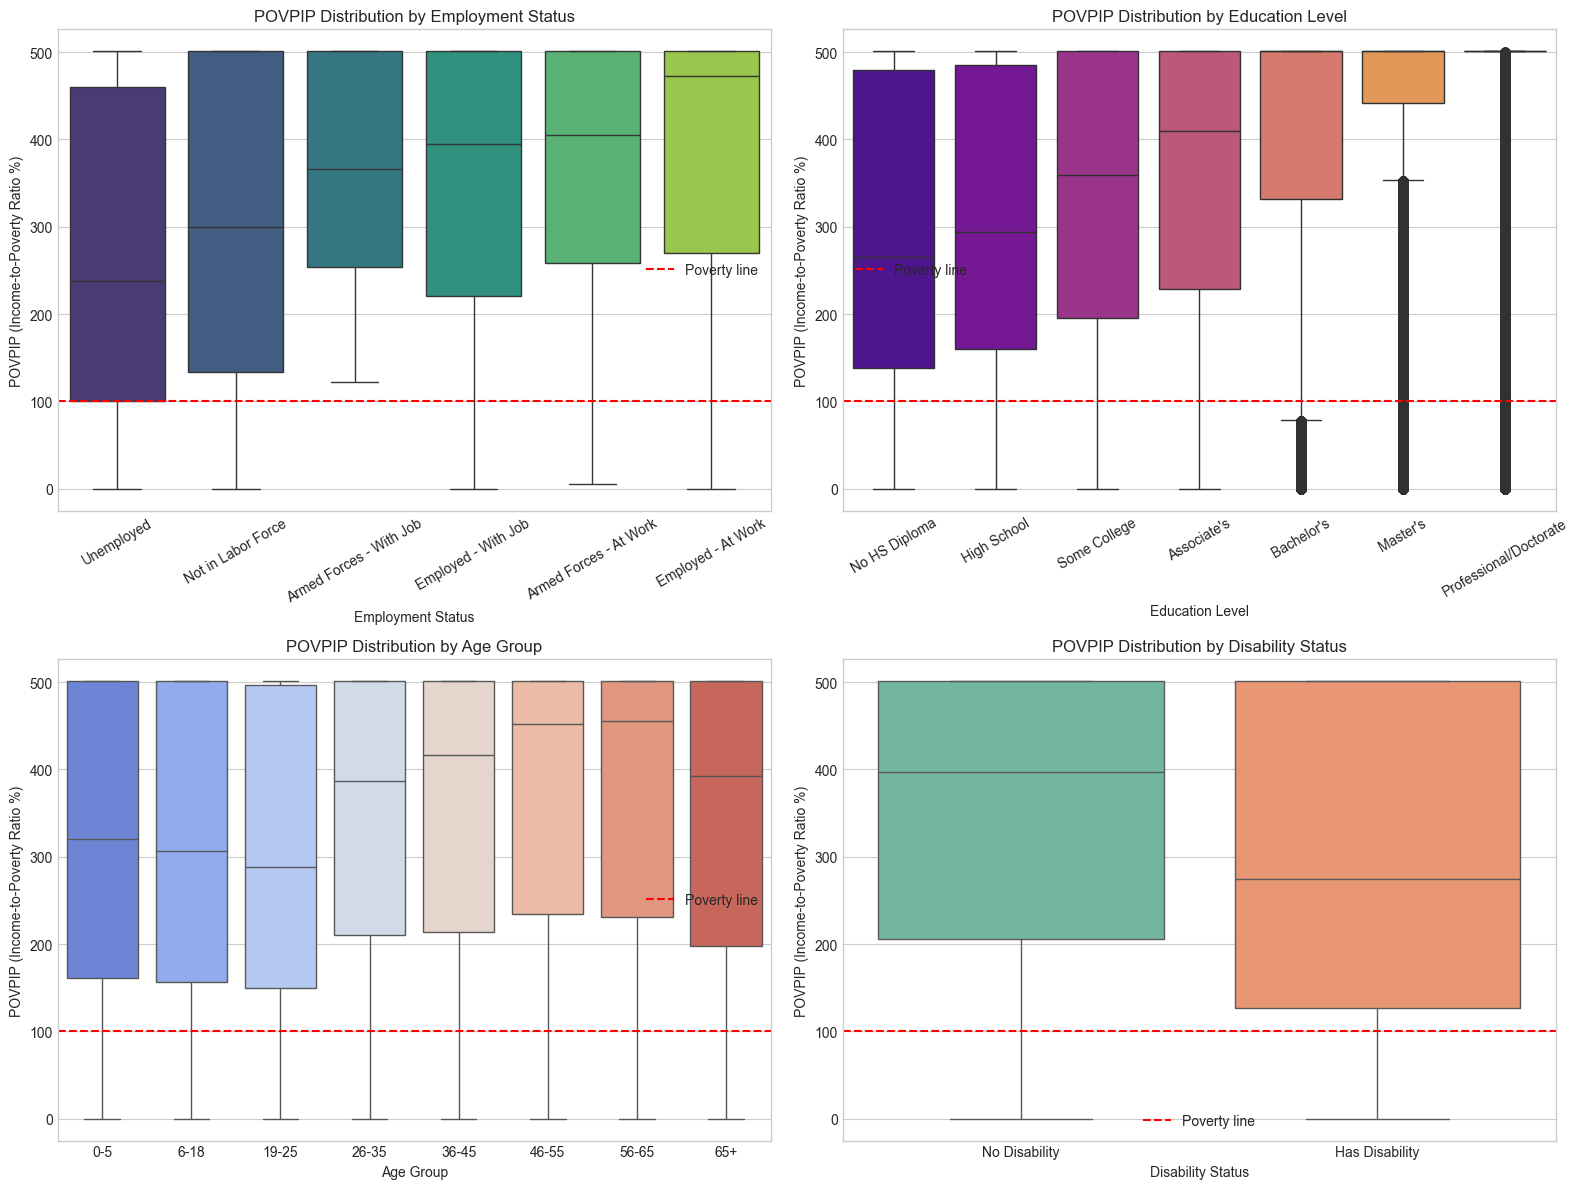

In [32]:
# Box Plots: POVPIP Distribution by Key Categories
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. POVPIP by Employment Status
df_box = df_analysis.dropna(subset=['employment', 'POVPIP'])
order = df_box.groupby('employment')['POVPIP'].median().sort_values().index
sns.boxplot(data=df_box, x='employment', y='POVPIP', order=order, ax=axes[0, 0], palette='viridis')
axes[0, 0].axhline(y=100, color='red', linestyle='--', label='Poverty line')
axes[0, 0].set_xlabel('Employment Status')
axes[0, 0].set_ylabel('POVPIP (Income-to-Poverty Ratio %)')
axes[0, 0].set_title('POVPIP Distribution by Employment Status')
axes[0, 0].tick_params(axis='x', rotation=30)
axes[0, 0].legend()

# 2. POVPIP by Education Level
df_box = df_analysis.dropna(subset=['education', 'POVPIP'])
edu_order = ['No HS Diploma', 'High School', 'Some College', "Associate's", "Bachelor's", "Master's", 'Professional/Doctorate']
sns.boxplot(data=df_box, x='education', y='POVPIP', order=edu_order, ax=axes[0, 1], palette='plasma')
axes[0, 1].axhline(y=100, color='red', linestyle='--', label='Poverty line')
axes[0, 1].set_xlabel('Education Level')
axes[0, 1].set_ylabel('POVPIP (Income-to-Poverty Ratio %)')
axes[0, 1].set_title('POVPIP Distribution by Education Level')
axes[0, 1].tick_params(axis='x', rotation=30)
axes[0, 1].legend()

# 3. POVPIP by Age Group
df_box = df_analysis.dropna(subset=['age_group', 'POVPIP'])
age_order = ['0-5', '6-18', '19-25', '26-35', '36-45', '46-55', '56-65', '65+']
sns.boxplot(data=df_box, x='age_group', y='POVPIP', order=age_order, ax=axes[1, 0], palette='coolwarm')
axes[1, 0].axhline(y=100, color='red', linestyle='--', label='Poverty line')
axes[1, 0].set_xlabel('Age Group')
axes[1, 0].set_ylabel('POVPIP (Income-to-Poverty Ratio %)')
axes[1, 0].set_title('POVPIP Distribution by Age Group')
axes[1, 0].legend()

# 4. POVPIP by Disability Status
df_box = df_analysis.dropna(subset=['disability', 'POVPIP'])
sns.boxplot(data=df_box, x='disability', y='POVPIP', ax=axes[1, 1], palette='Set2')
axes[1, 1].axhline(y=100, color='red', linestyle='--', label='Poverty line')
axes[1, 1].set_xlabel('Disability Status')
axes[1, 1].set_ylabel('POVPIP (Income-to-Poverty Ratio %)')
axes[1, 1].set_title('POVPIP Distribution by Disability Status')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('EDA_data/povpip_boxplots.png', dpi=150, bbox_inches='tight')
plt.show()

/var/folders/7w/j0bpp7hx3pbcmhhkspmsyjx40000gp/T/ipykernel_35057/3829491251.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_violin, x='sex', y='POVPIP', ax=axes[0], palette='Set1', inner='quartile')
/Users/marianne.sawires/.pyenv/versions/3.12.6/lib/python3.12/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/marianne.sawires/.pyenv/versions/3.12.6/lib/python3.12/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/marianne.sawires/.pyenv/versions/3.12.6/lib/python3.12/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/marianne.sawires/.pyenv/versions/3.12.6/lib/python3.12/s

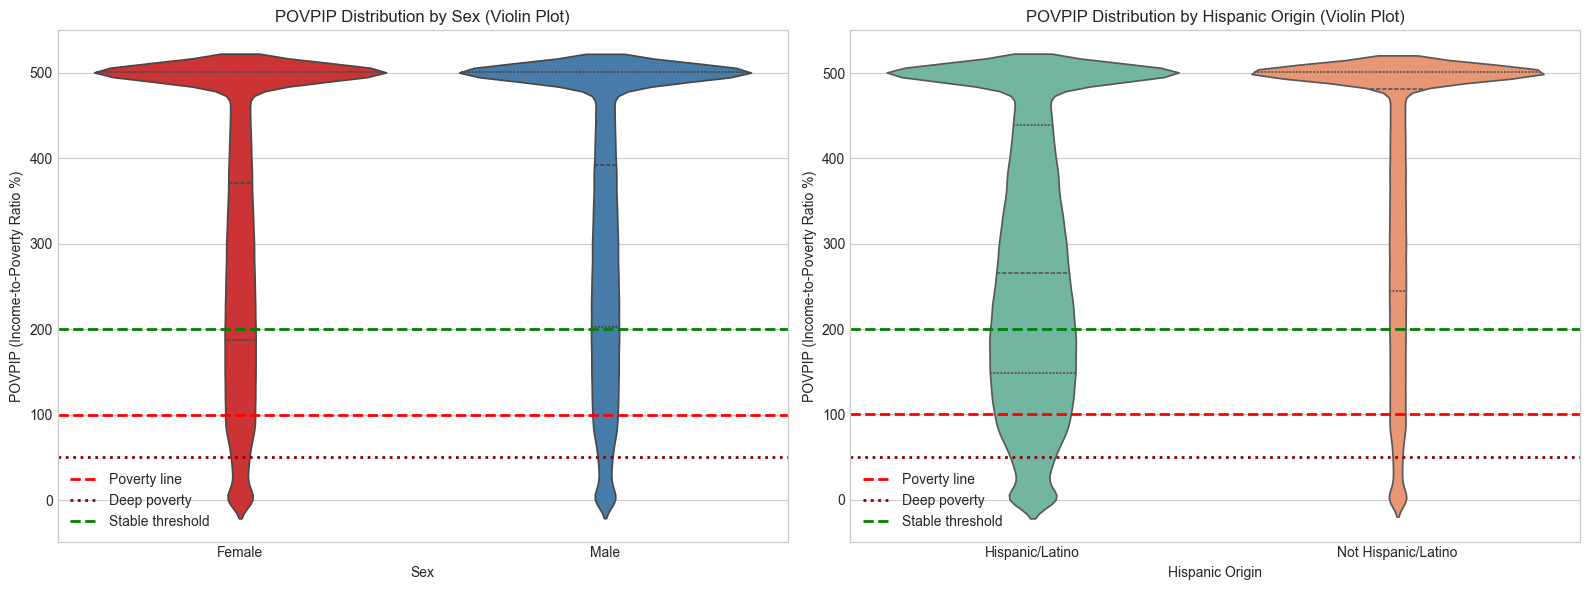

In [33]:
# Violin Plots: POVPIP Distribution showing density
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. POVPIP by Sex with violin plot
df_violin = df_analysis.dropna(subset=['sex', 'POVPIP'])
sns.violinplot(data=df_violin, x='sex', y='POVPIP', ax=axes[0], palette='Set1', inner='quartile')
axes[0].axhline(y=100, color='red', linestyle='--', linewidth=2, label='Poverty line')
axes[0].axhline(y=50, color='darkred', linestyle=':', linewidth=2, label='Deep poverty')
axes[0].axhline(y=200, color='green', linestyle='--', linewidth=2, label='Stable threshold')
axes[0].set_xlabel('Sex')
axes[0].set_ylabel('POVPIP (Income-to-Poverty Ratio %)')
axes[0].set_title('POVPIP Distribution by Sex (Violin Plot)')
axes[0].legend()

# 2. POVPIP by Hispanic Origin with violin plot
df_violin = df_analysis.dropna(subset=['hispanic', 'POVPIP'])
sns.violinplot(data=df_violin, x='hispanic', y='POVPIP', ax=axes[1], palette='Set2', inner='quartile')
axes[1].axhline(y=100, color='red', linestyle='--', linewidth=2, label='Poverty line')
axes[1].axhline(y=50, color='darkred', linestyle=':', linewidth=2, label='Deep poverty')
axes[1].axhline(y=200, color='green', linestyle='--', linewidth=2, label='Stable threshold')
axes[1].set_xlabel('Hispanic Origin')
axes[1].set_ylabel('POVPIP (Income-to-Poverty Ratio %)')
axes[1].set_title('POVPIP Distribution by Hispanic Origin (Violin Plot)')
axes[1].legend()

plt.tight_layout()
plt.savefig('EDA_data/povpip_violinplots.png', dpi=150, bbox_inches='tight')
plt.show()

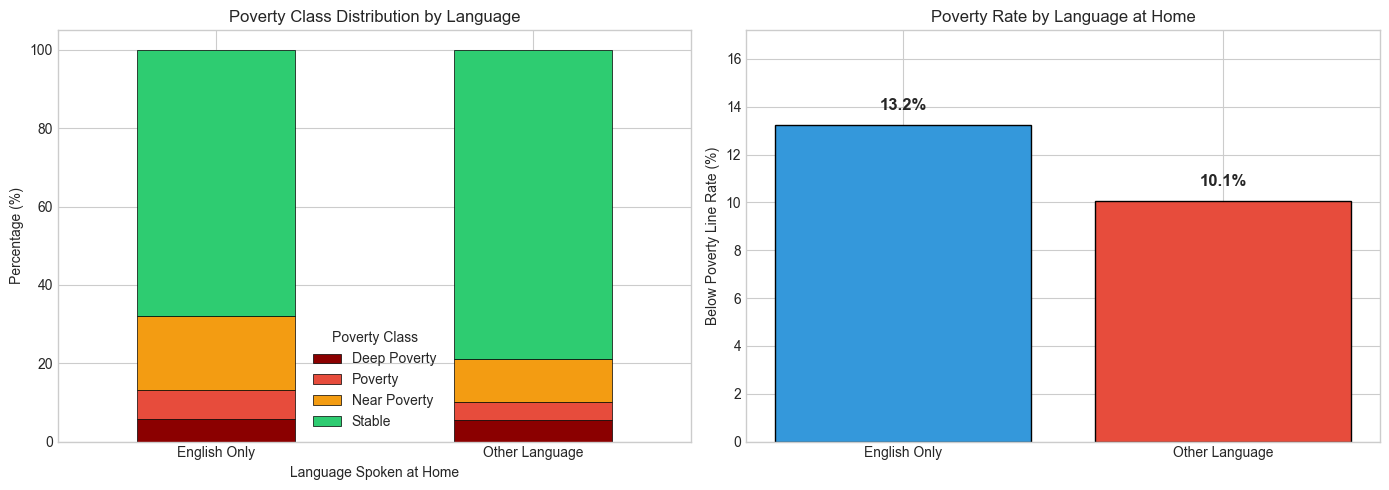


Poverty Rate by Language:
  English Only: 13.2%
  Other Language: 10.1%


In [34]:
# Poverty by Language Spoken at Home (LANX)
lanx_mapping = {1: 'English Only', 2: 'Other Language'}
df_analysis['language'] = df_analysis['LANX'].map(lanx_mapping)

lang_dist = df_analysis.dropna(subset=['language']).groupby(['language', 'poverty_class']).size().unstack(fill_value=0)
lang_dist = lang_dist[class_order]
lang_dist_pct = lang_dist.div(lang_dist.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar chart
lang_dist_pct.plot(kind='bar', stacked=True, ax=axes[0],
                   color=[class_colors[c] for c in class_order], edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Language Spoken at Home')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_title('Poverty Class Distribution by Language')
axes[0].legend(title='Poverty Class')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Comparison bar chart
vulnerable_lang = lang_dist_pct['Deep Poverty'] + lang_dist_pct['Poverty']
colors_bar = ['#3498db', '#e74c3c']
bars = axes[1].bar(vulnerable_lang.index, vulnerable_lang.values, color=colors_bar, edgecolor='black')
axes[1].set_ylabel('Below Poverty Line Rate (%)')
axes[1].set_title('Poverty Rate by Language at Home')
axes[1].set_ylim(0, max(vulnerable_lang.values) * 1.3)

for bar, rate in zip(bars, vulnerable_lang.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'{rate:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('EDA_data/poverty_class_by_language.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPoverty Rate by Language:")
for lang, rate in vulnerable_lang.items():
    print(f"  {lang}: {rate:.1f}%")

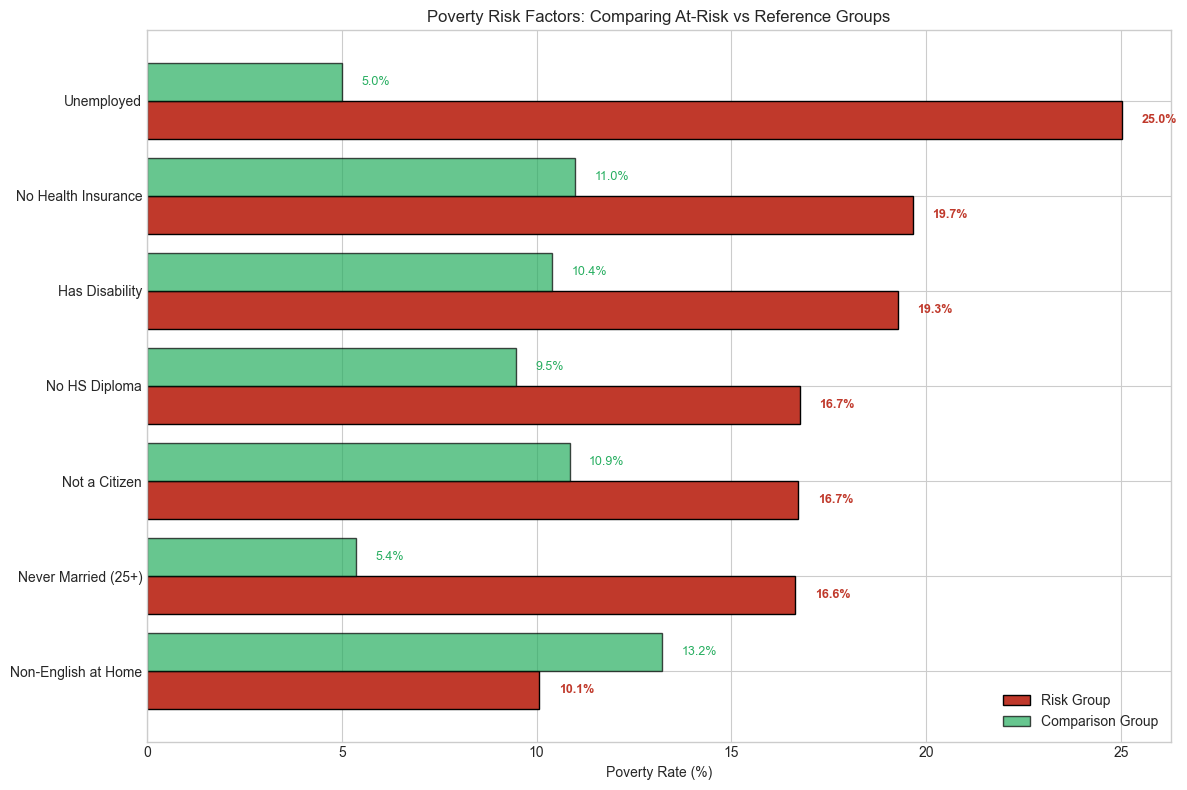


=== Poverty Risk Factor Summary ===
Factor                       At-Risk   Baseline   Difference
------------------------------------------------------------
Unemployed                     25.0%       5.0%       +20.0%
Never Married (25+)            16.6%       5.4%       +11.3%
Has Disability                 19.3%      10.4%        +8.9%
No Health Insurance            19.7%      11.0%        +8.7%
No HS Diploma                  16.7%       9.5%        +7.3%
Not a Citizen                  16.7%      10.9%        +5.9%
Non-English at Home            10.1%      13.2%        -3.2%


In [35]:
# Summary: Risk Factor Comparison Chart
# Calculate poverty rates for key binary/categorical risk factors

risk_factors = []

# Disability
has_dis = df_analysis[df_analysis['DIS'] == 1]['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
no_dis = df_analysis[df_analysis['DIS'] == 2]['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
risk_factors.append({'Factor': 'Has Disability', 'Rate': has_dis, 'Baseline': no_dis})

# No Health Insurance
no_ins = df_analysis[df_analysis['HICOV'] == 2]['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
has_ins = df_analysis[df_analysis['HICOV'] == 1]['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
risk_factors.append({'Factor': 'No Health Insurance', 'Rate': no_ins, 'Baseline': has_ins})

# Unemployed
unemployed = df_analysis[df_analysis['ESR'] == 3]['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
employed = df_analysis[df_analysis['ESR'].isin([1, 2])]['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
risk_factors.append({'Factor': 'Unemployed', 'Rate': unemployed, 'Baseline': employed})

# No HS Diploma
no_hs = df_analysis[df_analysis['education'] == 'No HS Diploma']['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
has_hs = df_analysis[df_analysis['education'] != 'No HS Diploma']['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
risk_factors.append({'Factor': 'No HS Diploma', 'Rate': no_hs, 'Baseline': has_hs})

# Not a Citizen
not_cit = df_analysis[df_analysis['CIT'] == 5]['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
is_cit = df_analysis[df_analysis['CIT'] != 5]['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
risk_factors.append({'Factor': 'Not a Citizen', 'Rate': not_cit, 'Baseline': is_cit})

# Other Language at Home
other_lang = df_analysis[df_analysis['LANX'] == 2]['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
english = df_analysis[df_analysis['LANX'] == 1]['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
risk_factors.append({'Factor': 'Non-English at Home', 'Rate': other_lang, 'Baseline': english})

# Never Married (adults 25+)
never_mar = df_analysis[(df_analysis['MAR'] == 5) & (df_analysis['AGEP'] >= 25)]['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
married = df_analysis[(df_analysis['MAR'] == 1) & (df_analysis['AGEP'] >= 25)]['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
risk_factors.append({'Factor': 'Never Married (25+)', 'Rate': never_mar, 'Baseline': married})

rf_df = pd.DataFrame(risk_factors)
rf_df['Difference'] = rf_df['Rate'] - rf_df['Baseline']
rf_df = rf_df.sort_values('Rate', ascending=True)

fig, ax = plt.subplots(figsize=(12, 8))

# Create horizontal bar chart
y_pos = range(len(rf_df))
bars = ax.barh(y_pos, rf_df['Rate'], color='#c0392b', edgecolor='black', label='Risk Group', height=0.4)
bars2 = ax.barh([y + 0.4 for y in y_pos], rf_df['Baseline'], color='#27ae60', edgecolor='black', 
                label='Comparison Group', height=0.4, alpha=0.7)

ax.set_yticks([y + 0.2 for y in y_pos])
ax.set_yticklabels(rf_df['Factor'])
ax.set_xlabel('Poverty Rate (%)')
ax.set_title('Poverty Risk Factors: Comparing At-Risk vs Reference Groups', fontsize=12)
ax.legend(loc='lower right')

# Add rate labels
for i, (idx, row) in enumerate(rf_df.iterrows()):
    ax.text(row['Rate'] + 0.5, i, f'{row["Rate"]:.1f}%', va='center', fontsize=9, color='#c0392b', fontweight='bold')
    ax.text(row['Baseline'] + 0.5, i + 0.4, f'{row["Baseline"]:.1f}%', va='center', fontsize=9, color='#27ae60')

plt.tight_layout()
plt.savefig('EDA_data/poverty_risk_factors_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n=== Poverty Risk Factor Summary ===")
print(f"{'Factor':<25} {'At-Risk':>10} {'Baseline':>10} {'Difference':>12}")
print("-" * 60)
for _, row in rf_df.sort_values('Difference', ascending=False).iterrows():
    print(f"{row['Factor']:<25} {row['Rate']:>9.1f}% {row['Baseline']:>9.1f}% {row['Difference']:>+11.1f}%")

/var/folders/7w/j0bpp7hx3pbcmhhkspmsyjx40000gp/T/ipykernel_35057/1273110218.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pyramid_data = df_pyramid.groupby(['age_group', 'sex', 'vulnerable']).size().unstack(fill_value=0)
/var/folders/7w/j0bpp7hx3pbcmhhkspmsyjx40000gp/T/ipykernel_35057/1273110218.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  male_data = df_pyramid[df_pyramid['sex'] == 'Male'].groupby('age_group')['vulnerable'].value_counts(normalize=True).unstack(fill_value=0) * 100
/var/folders/7w/j0bpp7hx3pbcmhhkspmsyjx40000gp/T/ipykernel_35057/1273110218.py:19: FutureWarning: The default of ob

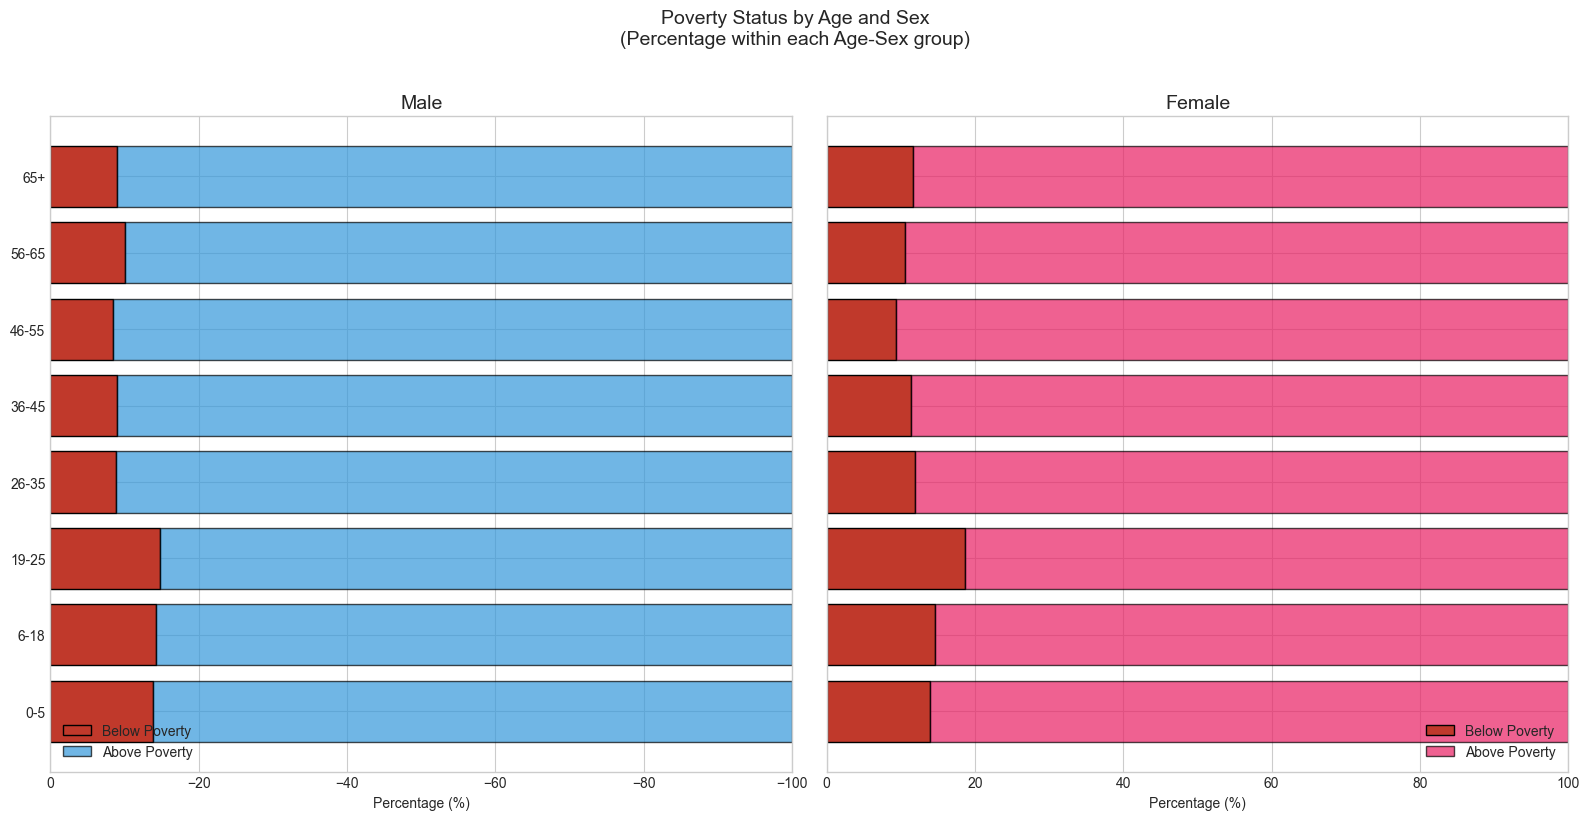


Poverty Rate by Age and Sex:

Male:
age_group
0-5      13.8
6-18     14.2
19-25    14.8
26-35     8.9
36-45     9.0
46-55     8.5
56-65    10.1
65+       9.0

Female:
age_group
0-5      13.9
6-18     14.6
19-25    18.7
26-35    12.0
36-45    11.3
46-55     9.4
56-65    10.5
65+      11.7


In [36]:
# Population Pyramid: Age Distribution by Sex and Poverty Status
df_pyramid = df_analysis.dropna(subset=['age_group', 'sex', 'poverty_class']).copy()

# Create vulnerable indicator
df_pyramid['vulnerable'] = df_pyramid['poverty_class'].isin(['Deep Poverty', 'Poverty'])

age_order = ['0-5', '6-18', '19-25', '26-35', '36-45', '46-55', '56-65', '65+']

# Calculate counts by age, sex, and vulnerability
pyramid_data = df_pyramid.groupby(['age_group', 'sex', 'vulnerable']).size().unstack(fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Left side: Male
male_data = df_pyramid[df_pyramid['sex'] == 'Male'].groupby('age_group')['vulnerable'].value_counts(normalize=True).unstack(fill_value=0) * 100
male_data = male_data.reindex(age_order)

# Right side: Female
female_data = df_pyramid[df_pyramid['sex'] == 'Female'].groupby('age_group')['vulnerable'].value_counts(normalize=True).unstack(fill_value=0) * 100
female_data = female_data.reindex(age_order)

# Plot Male (left, reversed)
y_pos = range(len(age_order))
axes[0].barh(y_pos, -male_data[True], color='#c0392b', label='Below Poverty', edgecolor='black')
axes[0].barh(y_pos, -male_data[False], left=-male_data[True], color='#3498db', label='Above Poverty', edgecolor='black', alpha=0.7)
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(age_order)
axes[0].set_xlabel('Percentage (%)')
axes[0].set_title('Male', fontsize=14)
axes[0].set_xlim(-100, 0)
axes[0].invert_xaxis()
axes[0].legend(loc='lower left')

# Plot Female (right)
axes[1].barh(y_pos, female_data[True], color='#c0392b', label='Below Poverty', edgecolor='black')
axes[1].barh(y_pos, female_data[False], left=female_data[True], color='#e91e63', label='Above Poverty', edgecolor='black', alpha=0.7)
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels([])
axes[1].set_xlabel('Percentage (%)')
axes[1].set_title('Female', fontsize=14)
axes[1].set_xlim(0, 100)
axes[1].legend(loc='lower right')

fig.suptitle('Poverty Status by Age and Sex\n(Percentage within each Age-Sex group)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('EDA_data/poverty_pyramid_age_sex.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPoverty Rate by Age and Sex:")
print("\nMale:")
print((male_data[True]).round(1).to_string())
print("\nFemale:")
print((female_data[True]).round(1).to_string())

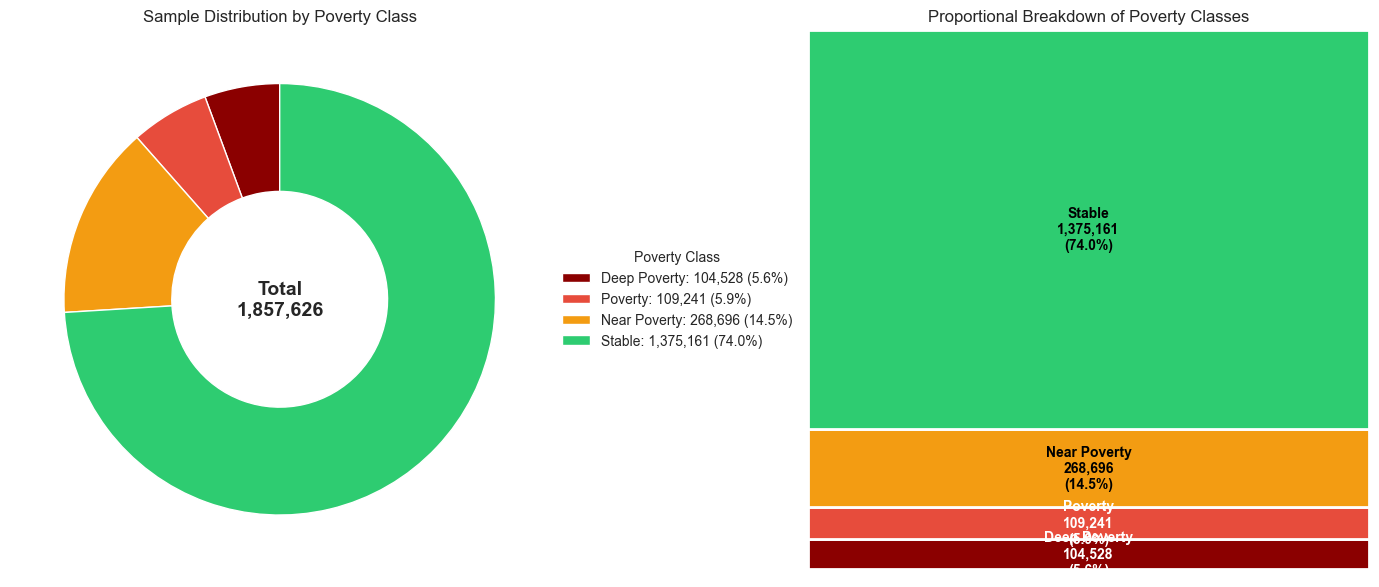


=== Sample Size Summary ===
Total records with valid POVPIP: 1,857,626

Breakdown by poverty class:
  Deep Poverty   :    104,528 (  5.6%)
  Poverty        :    109,241 (  5.9%)
  Near Poverty   :    268,696 ( 14.5%)
  Stable         :  1,375,161 ( 74.0%)


In [37]:
# Sample Size Overview: Class Breakdown with Counts
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Donut chart of poverty class distribution
class_counts = df_analysis['poverty_class'].value_counts().reindex(class_order)
colors = [class_colors[c] for c in class_order]

wedges, texts, autotexts = axes[0].pie(class_counts.values, labels=None, autopct='', 
                                        colors=colors, startangle=90, 
                                        wedgeprops=dict(width=0.5, edgecolor='white'))

# Add center text
total = class_counts.sum()
axes[0].text(0, 0, f'Total\n{total:,}', ha='center', va='center', fontsize=14, fontweight='bold')

# Custom legend with counts and percentages
legend_labels = [f'{cls}: {cnt:,} ({cnt/total*100:.1f}%)' for cls, cnt in zip(class_order, class_counts.values)]
axes[0].legend(wedges, legend_labels, title='Poverty Class', loc='center left', bbox_to_anchor=(1, 0.5))
axes[0].set_title('Sample Distribution by Poverty Class', fontsize=12)

# 2. Treemap-style breakdown
from matplotlib.patches import Rectangle

# Prepare data for treemap
class_data = pd.DataFrame({
    'Class': class_order,
    'Count': class_counts.values,
    'Pct': class_counts.values / total * 100
})

# Simple stacked bar to show proportions
bottom = 0
for i, row in class_data.iterrows():
    rect_height = row['Pct']
    axes[1].add_patch(Rectangle((0, bottom), 1, rect_height, 
                                  facecolor=class_colors[row['Class']], 
                                  edgecolor='white', linewidth=2))
    # Add label
    if rect_height > 5:  # Only label if big enough
        axes[1].text(0.5, bottom + rect_height/2, 
                     f"{row['Class']}\n{row['Count']:,}\n({row['Pct']:.1f}%)", 
                     ha='center', va='center', fontsize=10, fontweight='bold',
                     color='white' if row['Class'] in ['Deep Poverty', 'Poverty'] else 'black')
    bottom += rect_height

axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 100)
axes[1].axis('off')
axes[1].set_title('Proportional Breakdown of Poverty Classes', fontsize=12)

plt.tight_layout()
plt.savefig('EDA_data/poverty_class_breakdown.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n=== Sample Size Summary ===")
print(f"Total records with valid POVPIP: {total:,}")
print("\nBreakdown by poverty class:")
for cls in class_order:
    cnt = class_counts[cls]
    pct = cnt / total * 100
    print(f"  {cls:<15}: {cnt:>10,} ({pct:>5.1f}%)")